In [1]:
import torch
import numpy as np
import cv2
import os
from functools import partial
import itertools

import mafat_radar_challenge.data_loader.augmentation as module_aug
import mafat_radar_challenge.data_loader.data_loaders as module_data
import mafat_radar_challenge.model.loss as module_loss
import mafat_radar_challenge.model.metric as module_metric
import mafat_radar_challenge.model.model as module_arch
from mafat_radar_challenge.trainer import Trainer, MAFATTrainer
from mafat_radar_challenge.utils import setup_logger
from mafat_radar_challenge.tester import MAFATTester
import mafat_radar_challenge.data_loader.data_splitter as module_splitter
import mafat_radar_challenge.data_loader.samplers as module_sampler
import mafat_radar_challenge.data_loader.mixers as module_mix

from mafat_radar_challenge.main import get_instance, setup_device
from mafat_radar_challenge.cli import load_config

import matplotlib.pyplot as plt
from sklearn import metrics
from scipy.stats import pearsonr
import pandas as pd

In [1]:
def plot_roc_curve(gt, score, suffix=""):
    fpr, tpr, th = metrics.roc_curve(gt, score)
    auc = round(metrics.auc(fpr, tpr), 4)
    plt.semilogx(fpr, tpr, "-", label="AUC = {}".format(auc) + " " + suffix)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.grid(which="both")
    plt.legend()
    
def auc_score(gt, preds):
    fpr, tpr, th = metrics.roc_curve(gt, preds)
    return -metrics.auc(fpr, tpr)
    
def precision_recall_curve(gt, score, suffix=""):
    # fig = plt.figure(figsize=(15,10))
    prec, recall, th = metrics.precision_recall_curve(gt, score)
    # auc = metrics.auc(prec, recall)
    plt.plot(prec, recall, "-", label=suffix)#, label="AUC = {}".format(auc))
    plt.xlabel("Precision")
    plt.ylabel("Recall")
    plt.grid(which="both")
    plt.legend()
    
def plot_histogram(positive_preds, negative_preds):
    fig = plt.figure(figsize=(15,10))
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twinx()
    ax2.hist(positive_preds, alpha=0.6, log=False, label='+', cumulative=False, bins=30, color='orange')
    ax1.hist(negative_preds, alpha=0.4, log=False, label='-', cumulative=False, bins=30, color='blue')
    ax1.legend(loc=1)
    ax2.legend(loc=2)
    plt.show()
    
def plot_stacked_histogram(df, grouping_col="snr_type"):
    group_values = df[grouping_col].unique()
    positive_df = df[df.target_type == 1]
    negative_df = df[df.target_type == 0]    
        
    fig = plt.figure(figsize=(15,10))
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twinx()
    pos_colors = [y for x,y in zip(group_values, ["orange", "lime", "yellow"])]
    neg_colors = [y for x,y in zip(group_values, ["blue", "purple", "cyan"])]
    ax2.hist([positive_df.loc[positive_df[grouping_col] == x, "score"].values.tolist() for x in group_values], alpha=0.6, log=False, label=[x + ' +' for x in group_values], stacked=True, cumulative=False, bins=30, color=pos_colors)
    ax1.hist([negative_df.loc[negative_df[grouping_col] == x, "score"].values.tolist() for x in group_values], alpha=0.4, log=False, label=[x + ' -' for x in group_values], stacked=True, cumulative=False, bins=30, color=neg_colors)
    ax1.legend(loc=2)
    ax2.legend(loc=1)
    plt.show()
    
def plot_calibration_curves(gt, score, suffix=""):
    fpr, tpr, th = metrics.roc_curve(gt, score)
    fpr = np.clip(fpr, 0, 1)
    tpr = np.clip(tpr, 0, 1)
    th = np.clip(th, 0, 1)
    fnr = 1 - tpr
    plt.plot(th, fpr, label="FPR" + " " + suffix)
    plt.plot(th, fnr, label="FNR" + " " + suffix)
    #plt.yscale("log")
    plt.xlabel("TH")
    plt.ylabel("FPR & FNR")
    plt.grid(which="both")
    plt.legend()

# Val dataset

In [6]:
models = [
    #"/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_simple_aug_v5_adam/0808-140236/checkpoints/model_best.pth",
    #"/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b3_more_aux_more_synth_specaug_simple_aug_v5_adam/0809-140258/checkpoints/model_best.pth",
    #"/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b4_more_aux_more_synth_specaug_simple_aug_v5_adam/0810-114753/checkpoints/model_best.pth",
    #"/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b4_more_aux_more_synth_specaug_simpleR_aug_v5_adam/0811-082054/checkpoints/model_best.pth",
    #"/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_resnest50_more_aux_more_synth_specaug_simpleR_aug_v5_adam/0814-131357/checkpoints/model_best.pth",
    #"/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_deltas_simple_aug_v5_adam/0815-134247/checkpoints/model_best.pth",
    #"/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b5_more_aux_more_synth_specaug_simple_aug_v5_adam_sampler_02/0818-165929/checkpoints/model_best.pth",
    #"/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b3_more_aux_more_synth_specaug_simple_aug_v5_adam_sampler_02/0827-084851/checkpoints/model_best.pth",
    #"/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b3_specaug_simple_aug_v5_train_v5_val_sampler_013/0830-174729/checkpoints/model_best.pth",
    #"/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b4_more_aux_more_synth_specaug_simple_aug_v5_adam_sampler_02/0820-080532/checkpoints/model_best.pth",
    #"/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b3_specaug_simple_aug_v5_train_v5_val_sampler_013/0830-174729/checkpoints/model_best.pth",
    # "/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b4_specaug_simple_aug_v5_train_v5_val_no_sampler/0831-081207/checkpoints/model_best.pth",
    #"/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_resnest50_more_aux_more_synth_specaug_simpleR_aug_v5_adam_sampler_02/0821-200228/checkpoints/model_best.pth",
    #"/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_resnest50_specaug_simple_aug_v5_train_v5_val_sampler_02/0901-103301/checkpoints/model_best.pth",
    #"/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0905-131049/checkpoints/model_best.pth",
    #"/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0905-131049/checkpoints/checkpoint-epoch19.pth",
    #"/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_simple_aug_v5_adam_centered_rnd_crop_90/0905-231358/checkpoints/model_best.pth",
    #"/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_simple_aug_v8_adam/0906-104511/checkpoints/model_best.pth",
    #"/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_simple_aug_v8_adam/0906-104511/checkpoints/checkpoint-epoch19.pth",
    #"/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b4_more_aux_more_synth_specaug_simple_aug_v8_adam/0906-160951/checkpoints/model_best.pth",
    #"/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b4_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0908-144825/checkpoints/model_best.pth",
    #"/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_simple_aug_v5_adam_centered_w_burst/0909-203605/checkpoints/model_best.pth",
    #"/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_more_specaug_aug_v5_adam_centered/0910-203057/checkpoints/model_best.pth",
    #"/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b4_more_aux_more_synth_more_specaug_aug_v5_adam_centered_no_sampler/0911-082539/checkpoints/model_best.pth",
    #"/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_simple_aug_v5_adam_centered_mixer/0911-202903/checkpoints/model_best.pth",
    #"/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b3_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0912-121429/checkpoints/model_best.pth",
    #"/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_timm_b2_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0912-190748/checkpoints/model_best.pth",
    #"/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b3_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0912-121429/checkpoints/checkpoint-epoch11-20.pth",
    #"/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b3_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0912-121429/checkpoints/checkpoint-epoch11-15.pth",
    #"/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b3_more_aux_more_synth_specaug_simple_aug_v5_adam_centered_rnd_crop_90/0916-173224/checkpoints/model_best.pth", # Special augmentation
    #"/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b3_more_aux_more_synth_specaug_simple_aug_v5_adam_centered_bs/0917-132142/checkpoints/model_best.pth", # Special augmentation
    #"/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b1_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0913-154517/checkpoints/model_best.pth",
    #"/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_resnest50_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0918-193440/checkpoints/model_best.pth",
    #"/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_simple_aug_v5_adam_centered_REPLICA/0919-102132/checkpoints/model_best.pth",
    #"/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_simple_aug_v5_adam_centered_REPLICA_nodet/0919-152758/checkpoints/model_best.pth",
    #"/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_simple_aug_v5_adam_centered_REPLICA/0919-102132/checkpoints/checkpoint-epoch13.pth",
    #"/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_simple_aug_v9_adam_centered/0920-104137/checkpoints/model_best.pth",
    #"/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b5_more_aux_more_synth_specaug_simple_aug_v7_adam_centered/0920-155059/checkpoints/model_best.pth",
    #"/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b5_more_aux_more_synth_specaug_simple_aug_v7_adam_centered/0920-155059/checkpoints/checkpoint-epoch11.pth",
    #"/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_resnest50_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0918-193440/checkpoints/checkpoint-epoch23.pth",
    #"/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_simple_aug_v8_adam/0906-104511/checkpoints/checkpoint-epoch11.pth",
    "/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_timm_b2_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0912-190748/checkpoints/checkpoint-epoch11.pth",
    "/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_timm_b2_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0912-190748/checkpoints/model_best.pth"
    
]

WITHOUT_SYNTH_NOISE = True

In [7]:
# cfg = load_config(CONFIG_PATH)
preds_list = list()
gt_list = list()
for model_path in models:
    # Setup
    cfg = load_config(os.path.join(os.path.dirname(model_path), "config.yml"))
    transforms = get_instance(module_aug, "augmentation", cfg)
    if "sampler" in cfg:
        sampler = getattr(module_sampler, cfg["sampler"]["type"])
        sampler = partial(sampler, **cfg["sampler"]["args"])
    else:
        sampler = None
    # cfg["data_loader"]["args"]["sampler"] = sampler
    
    # Without synth noise
    #if WITHOUT_SYNTH_NOISE: 
    #    cfg["val_data_loader"]["args"]["data_dir"] = "/home/agarcia/repos/mafat-radar-challenge/mafat_radar_challenge/data/mafat_val_v4_spectrogram.npy"
    #    cfg["val_data_loader"]["args"]["csv_dir"] = "/home/agarcia/repos/mafat-radar-challenge/mafat_radar_challenge/data/mafat_val_v4.csv"
    
    if "mixer" in cfg:
        mixer = get_instance(module_mix, "mixer", cfg)
    else:
        mixer = None
    data_loader = get_instance(module_data, "data_loader", cfg, transforms, sampler, mixer)
    valid_data_loader = get_instance(module_data, "val_data_loader", cfg, transforms, sampler)
    validation_df = valid_data_loader.dataset.df.copy()
    model = get_instance(module_arch, "arch", cfg)
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint["state_dict"])
    model, device = setup_device(model, cfg["target_devices"])
    model.eval()

    # Predict
    counter = 0
    preds = list()
    gt = list()
    with torch.no_grad():
        for idx, (image_batch, label_batch) in enumerate(valid_data_loader):
            if isinstance(image_batch, list):
                for i, _ in enumerate(image_batch):
                    image_batch[i] = image_batch[i].to(device)
                data = image_batch
            else:
                data = image_batch.to(device)
            output = model(data).cpu()
            output = torch.sigmoid(output)
            preds.append(output.cpu().numpy())
            #for idx_2, (image, label) in enumerate(zip(image_batch[0], label_batch)):
            for idx_2, (image, label) in enumerate(zip(image_batch, label_batch)):
                gt.append(label[0].cpu().numpy())
                
    preds = np.vstack(preds).reshape(-1).tolist()
    gt = np.vstack(gt).reshape(-1).tolist()
    if WITHOUT_SYNTH_NOISE:
        preds = preds[:309]
        gt = gt[:309]
        assert len(preds) == 309
    
    gt_list.append(gt)
    preds_list.append(preds)

In [8]:
for gt, preds, model in zip(gt_list, preds_list, models):
    print(model)
    print("\t BCE: ", metrics.log_loss(gt, preds))
    fpr, tpr, th = metrics.roc_curve(gt, preds)
    print("\t AUC: ", metrics.auc(fpr, tpr))

/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_timm_b2_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0912-190748/checkpoints/checkpoint-epoch11.pth
	 BCE:  0.15279233404456843
	 AUC:  0.990146750524109
/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_timm_b2_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0912-190748/checkpoints/model_best.pth
	 BCE:  0.1665830792935335
	 AUC:  0.9837316561844864


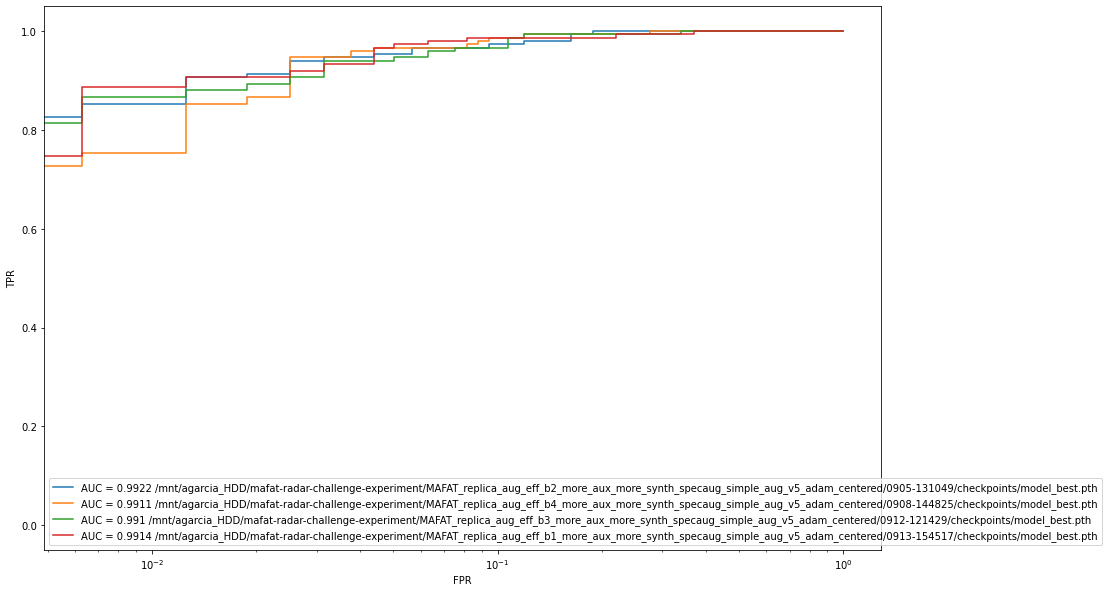

In [6]:
fig = plt.figure(figsize=(15,10))
for gt, preds, model in zip(gt_list, preds_list, models):
    plot_roc_curve(gt, preds, model)

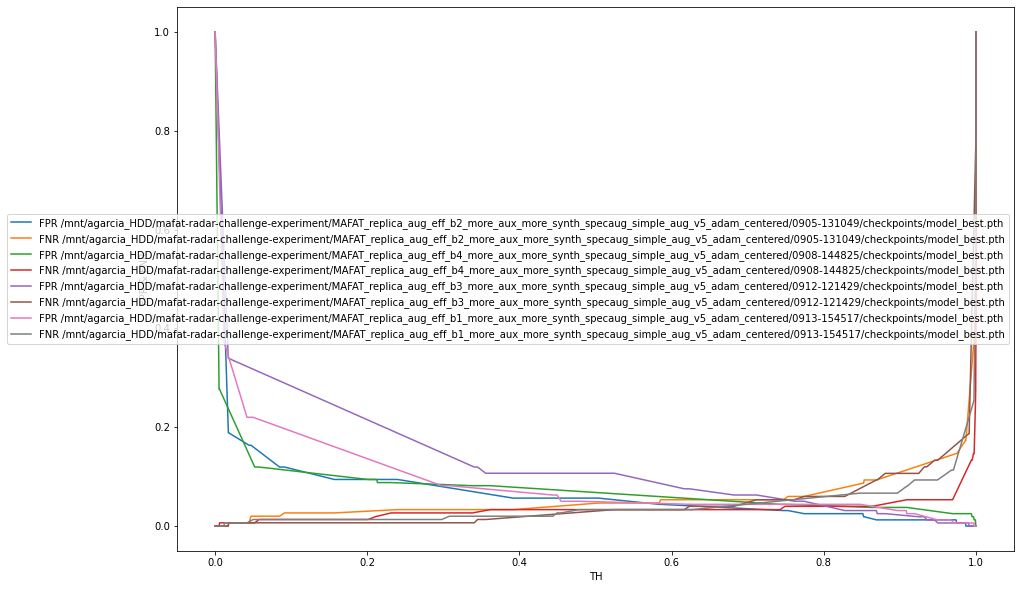

In [7]:
fig = plt.figure(figsize=(15,10))
for gt, preds, model in zip(gt_list, preds_list, models):
    plot_calibration_curves(gt, preds, model)

/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0905-131049/checkpoints/model_best.pth


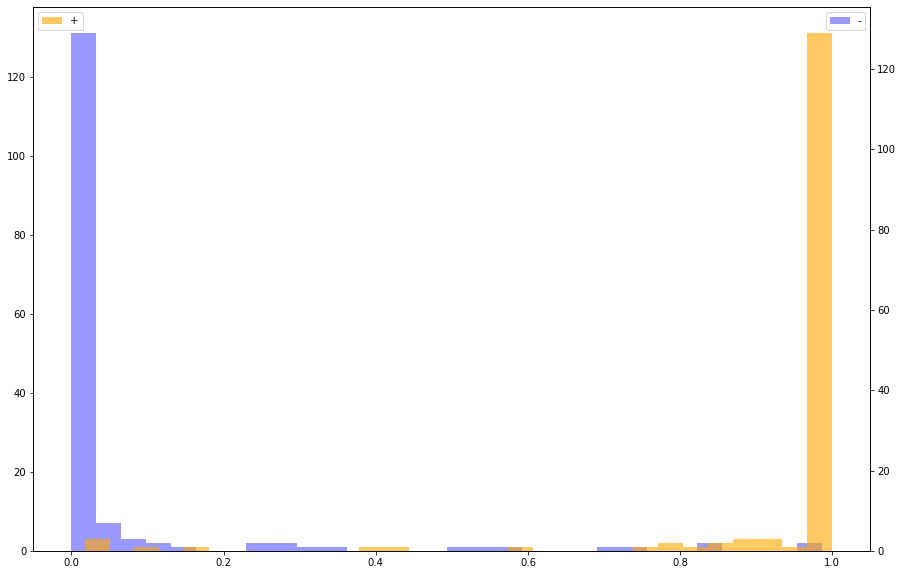

/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b4_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0908-144825/checkpoints/model_best.pth


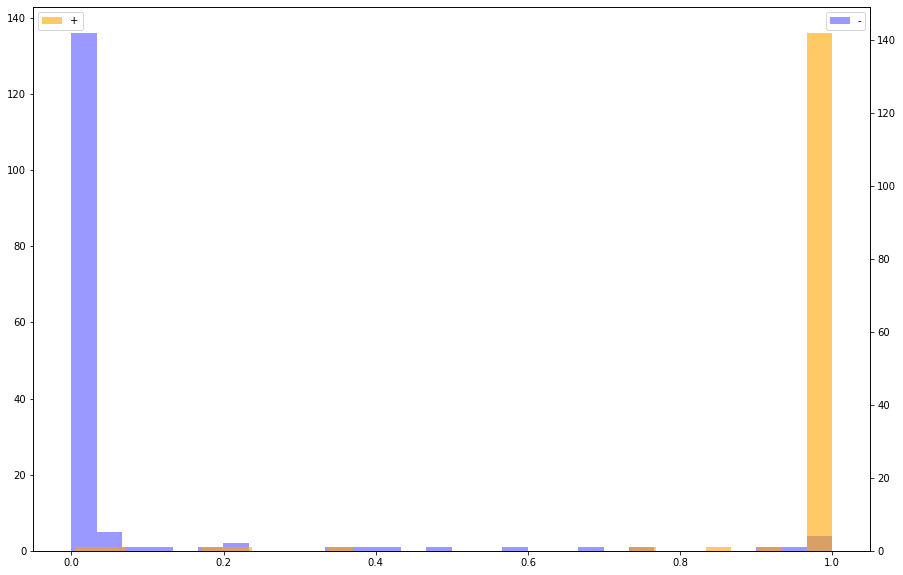

/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b3_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0912-121429/checkpoints/model_best.pth


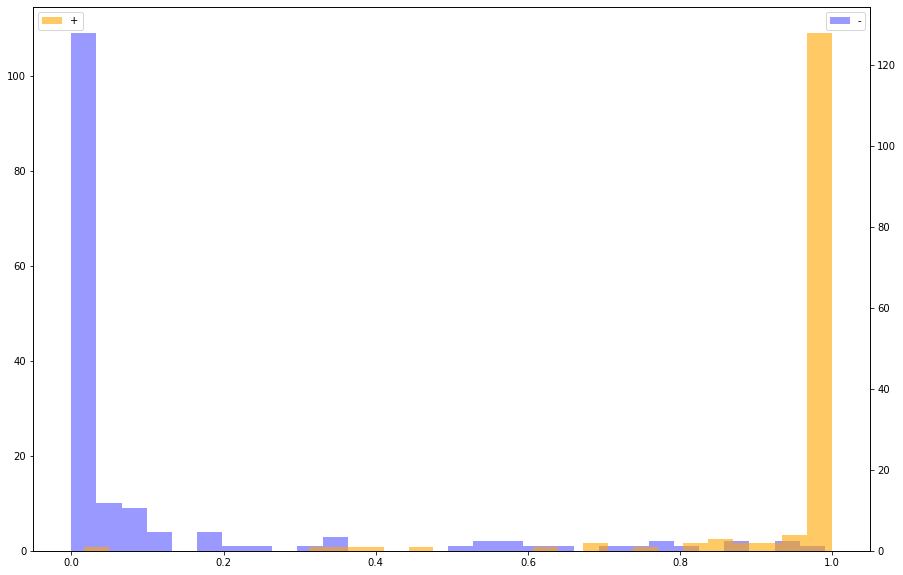

/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b1_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0913-154517/checkpoints/model_best.pth


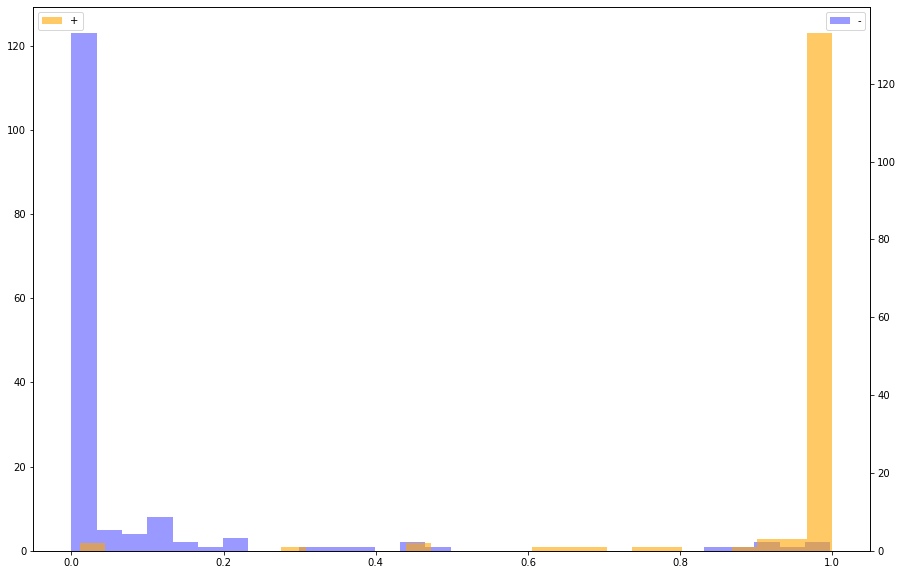

In [8]:
for gt, preds, model in zip(gt_list, preds_list, models):
    positive_preds = [p for (g,p) in zip(gt, preds) if g == 1]
    negative_preds = [p for (g,p) in zip(gt, preds) if g == 0]
    print(model)
    plot_histogram(positive_preds, negative_preds)

/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0905-131049/checkpoints/model_best.pth


/home/agarcia/miniconda2/envs/mafat_radar_challenge/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


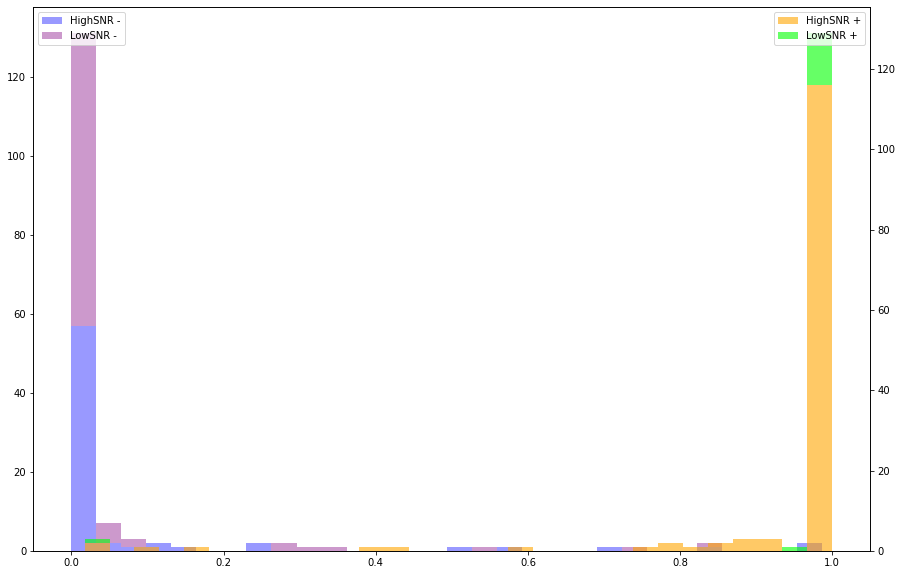

/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b4_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0908-144825/checkpoints/model_best.pth


/home/agarcia/miniconda2/envs/mafat_radar_challenge/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


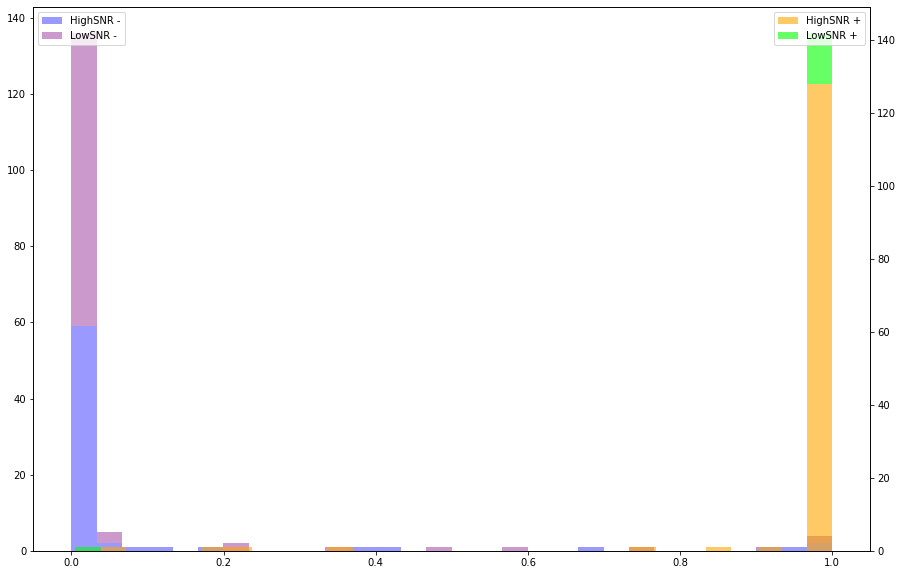

/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b3_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0912-121429/checkpoints/model_best.pth


/home/agarcia/miniconda2/envs/mafat_radar_challenge/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


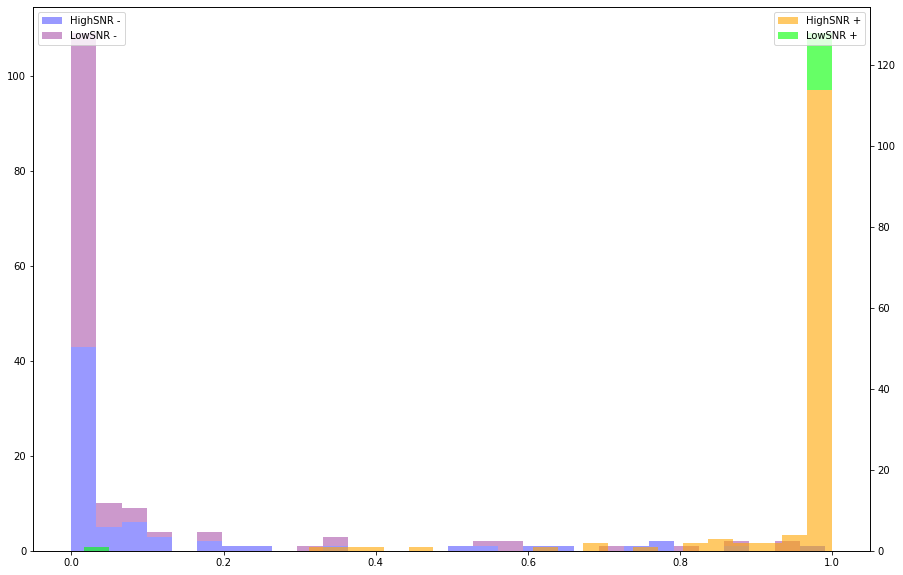

/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b1_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0913-154517/checkpoints/model_best.pth


/home/agarcia/miniconda2/envs/mafat_radar_challenge/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


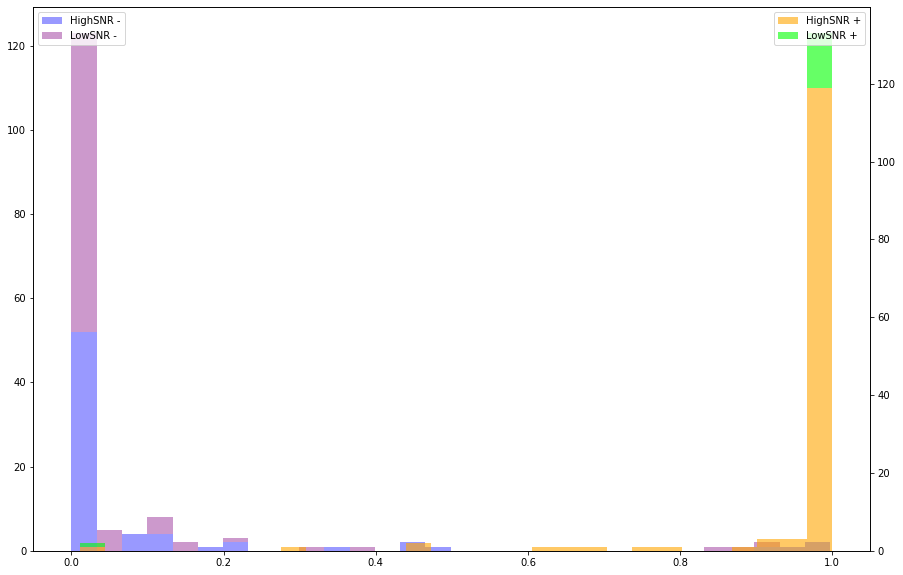

In [26]:
for gt, preds, model in zip(gt_list, preds_list, models):
    if WITHOUT_SYNTH_NOISE:
        preds = preds[:309]
        gt = gt[:309]
        aux_validation_df = validation_df.iloc[:309, :].copy()
        assert len(preds) == 309
    else:
        aux_validation_df = validation_df.copy()
    aux_validation_df.loc[:, "score"] = preds
    print(model)
    plot_stacked_histogram(aux_validation_df)

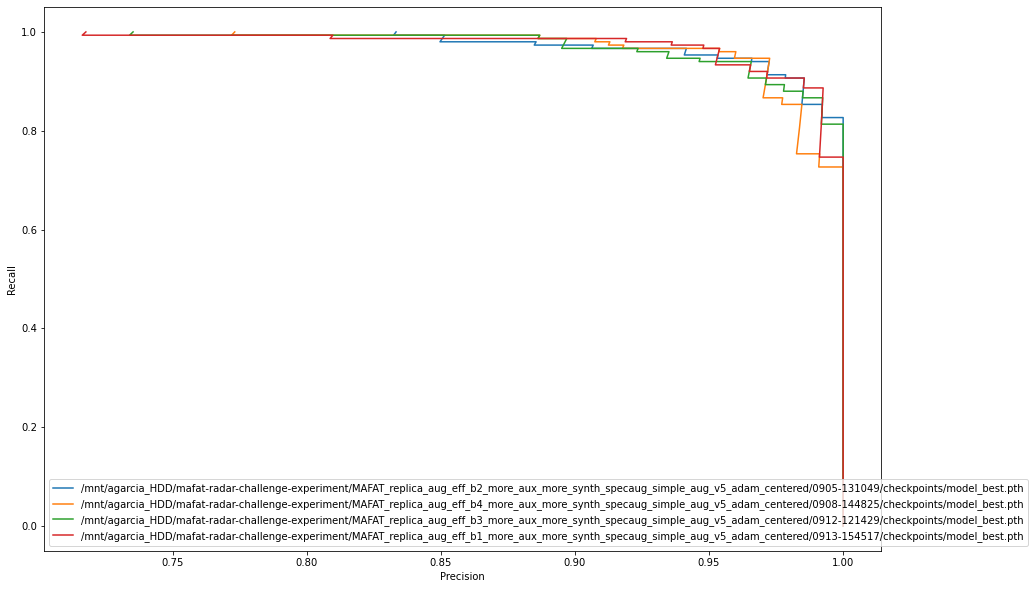

In [28]:
fig = plt.figure(figsize=(15,10))
for gt, preds, model in zip(gt_list, preds_list, models):
    precision_recall_curve(gt, preds, model)

In [48]:
validation_df.groupby(["target_type", "snr_type"]).count()

index  segment_id  track_id  geolocation_type  \
target_type snr_type                                                  
0           HighSNR      71          71        71                71   
            LowSNR       88          88        88                88   
            SynthSNR     71          71        71                71   
1           HighSNR     135         135       135               135   
            LowSNR       15          15        15                15   
            SynthSNR    135         135       135               135   

                      geolocation_id  sensor_id  date_index  source  
target_type snr_type                                                 
0           HighSNR               71         71          71      71  
            LowSNR                88         88          88      88  
            SynthSNR              71         71          71      71  
1           HighSNR              135        135         135     135  
            LowSNR                15         15          15      15  
            SynthSNR             135        135         135     135

In [32]:
# False positives
for gt, preds, model in zip(gt_list, preds_list, models):
    print(model)
    aux_df = validation_df.copy()    
    if WITHOUT_SYNTH_NOISE:
        preds = preds[:309]
        gt = gt[:309]
        aux_df = aux_df.iloc[:309, :]
        assert len(preds) == 309
    aux_df["score"] = preds
    display(aux_df[(aux_df.score > 0.4) & (aux_df.target_type == 0)])

/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0905-131049/checkpoints/model_best.pth


,index,segment_id,track_id,geolocation_type,geolocation_id,sensor_id,snr_type,date_index,target_type,source,score
7,7,42,36,C,1,1,HighSNR,27,0,train,0.851278
8,8,48,36,C,1,1,HighSNR,27,0,train,0.986272
9,9,54,37,C,1,1,HighSNR,27,0,train,0.973679
45,45,270,246,D,4,4,HighSNR,30,0,train,0.503841
57,57,342,302,D,4,4,HighSNR,32,0,train,0.585445
69,69,414,344,D,4,4,HighSNR,32,0,train,0.712482
81,81,1716,59,C,1,1,LowSNR,27,0,train,0.752940
106,106,1866,187,C,1,1,LowSNR,24,0,train,0.852951
128,128,1998,264,D,4,4,LowSNR,31,0,train,0.540877


/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b4_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0908-144825/checkpoints/model_best.pth


,index,segment_id,track_id,geolocation_type,geolocation_id,sensor_id,snr_type,date_index,target_type,source,score
6,6,36,34,C,1,1,HighSNR,27,0,train,0.411091
7,7,42,36,C,1,1,HighSNR,27,0,train,0.909115
8,8,48,36,C,1,1,HighSNR,27,0,train,0.999506
9,9,54,37,C,1,1,HighSNR,27,0,train,0.999233
18,18,108,104,C,1,1,HighSNR,26,0,train,0.965712
62,62,372,316,D,4,4,HighSNR,32,0,train,0.675487
81,81,1716,59,C,1,1,LowSNR,27,0,train,0.748948
86,86,1746,118,C,1,1,LowSNR,26,0,train,0.996689
106,106,1866,187,C,1,1,LowSNR,24,0,train,0.993848
110,110,1890,200,C,1,1,LowSNR,24,0,train,0.577635


/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b3_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0912-121429/checkpoints/model_best.pth


,index,segment_id,track_id,geolocation_type,geolocation_id,sensor_id,snr_type,date_index,target_type,source,score
5,5,30,32,C,1,1,HighSNR,27,0,train,0.776765
7,7,42,36,C,1,1,HighSNR,27,0,train,0.773975
8,8,48,36,C,1,1,HighSNR,27,0,train,0.990117
9,9,54,37,C,1,1,HighSNR,27,0,train,0.745131
12,12,72,49,C,1,1,HighSNR,27,0,train,0.524776
35,35,210,195,C,1,1,HighSNR,24,0,train,0.623248
54,54,324,270,D,4,4,HighSNR,31,0,train,0.536098
57,57,342,302,D,4,4,HighSNR,32,0,train,0.868993
62,62,372,316,D,4,4,HighSNR,32,0,train,0.649865
81,81,1716,59,C,1,1,LowSNR,27,0,train,0.802109


/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b1_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0913-154517/checkpoints/model_best.pth


,index,segment_id,track_id,geolocation_type,geolocation_id,sensor_id,snr_type,date_index,target_type,source,score
5,5,30,32,C,1,1,HighSNR,27,0,train,0.449453
7,7,42,36,C,1,1,HighSNR,27,0,train,0.937039
8,8,48,36,C,1,1,HighSNR,27,0,train,0.997157
9,9,54,37,C,1,1,HighSNR,27,0,train,0.967759
45,45,270,246,D,4,4,HighSNR,30,0,train,0.478099
49,49,294,254,D,4,4,HighSNR,30,0,train,0.454359
57,57,342,302,D,4,4,HighSNR,32,0,train,0.919211
81,81,1716,59,C,1,1,LowSNR,27,0,train,0.847642
86,86,1746,118,C,1,1,LowSNR,26,0,train,0.908293
106,106,1866,187,C,1,1,LowSNR,24,0,train,0.889687


In [34]:
# False negatives
for gt, preds, model in zip(gt_list, preds_list, models):
    print(model)
    aux_df = validation_df.copy()    
    if WITHOUT_SYNTH_NOISE:
        preds = preds[:309]
        gt = gt[:309]
        aux_df = aux_df.iloc[:309, :]
        assert len(preds) == 309
    aux_df["score"] = preds
    display(aux_df[(aux_df.score < 0.6) & (aux_df.target_type == 1)])

/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0905-131049/checkpoints/model_best.pth


,index,segment_id,track_id,geolocation_type,geolocation_id,sensor_id,snr_type,date_index,target_type,source,score
177,177,5868,26,C,1,1,HighSNR,27,1,train,0.045891
188,188,5934,60,C,1,1,HighSNR,27,1,train,0.084709
197,197,5988,68,C,1,1,HighSNR,28,1,train,0.044599
205,205,6036,81,C,1,1,HighSNR,28,1,train,0.156730
206,206,6042,84,C,1,1,HighSNR,28,1,train,0.583530
214,214,6090,99,C,1,1,HighSNR,26,1,train,0.440565
270,270,6426,279,D,4,4,HighSNR,31,1,train,0.391644
294,294,6570,18,C,1,1,LowSNR,27,1,train,0.017441


/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b4_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0908-144825/checkpoints/model_best.pth


,index,segment_id,track_id,geolocation_type,geolocation_id,sensor_id,snr_type,date_index,target_type,source,score
177,177,5868,26,C,1,1,HighSNR,27,1,train,0.213263
188,188,5934,60,C,1,1,HighSNR,27,1,train,0.052046
197,197,5988,68,C,1,1,HighSNR,28,1,train,0.338295
208,208,6054,95,C,1,1,HighSNR,26,1,train,0.200922
294,294,6570,18,C,1,1,LowSNR,27,1,train,0.005191


/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b3_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0912-121429/checkpoints/model_best.pth


,index,segment_id,track_id,geolocation_type,geolocation_id,sensor_id,snr_type,date_index,target_type,source,score
188,188,5934,60,C,1,1,HighSNR,27,1,train,0.340522
249,249,6300,217,D,4,4,HighSNR,33,1,train,0.355596
270,270,6426,279,D,4,4,HighSNR,31,1,train,0.392778
276,276,6462,284,D,4,4,HighSNR,31,1,train,0.454388
294,294,6570,18,C,1,1,LowSNR,27,1,train,0.017262


/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b1_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0913-154517/checkpoints/model_best.pth


,index,segment_id,track_id,geolocation_type,geolocation_id,sensor_id,snr_type,date_index,target_type,source,score
188,188,5934,60,C,1,1,HighSNR,27,1,train,0.041948
206,206,6042,84,C,1,1,HighSNR,28,1,train,0.454587
208,208,6054,95,C,1,1,HighSNR,26,1,train,0.443693
249,249,6300,217,D,4,4,HighSNR,33,1,train,0.297863
294,294,6570,18,C,1,1,LowSNR,27,1,train,0.011844


## T-SNE

In [41]:
# cfg = load_config(CONFIG_PATH)
preds_list = list()
gt_list = list()
output_list = list()
for model_path in models:
    # Setup
    cfg = load_config(os.path.join(os.path.dirname(model_path), "config.yml"))
    transforms = get_instance(module_aug, "augmentation", cfg)
    if "sampler" in cfg:
        sampler = getattr(module_sampler, cfg["sampler"]["type"])
        sampler = partial(sampler, **cfg["sampler"]["args"])
    else:
        sampler = None
        
    # Without synth noise
    #if WITHOUT_SYNTH_NOISE: 
    #    cfg["val_data_loader"]["args"]["data_dir"] = "/home/agarcia/repos/mafat-radar-challenge/mafat_radar_challenge/data/mafat_val_v4_spectrogram.npy"
    #    cfg["val_data_loader"]["args"]["csv_dir"] = "/home/agarcia/repos/mafat-radar-challenge/mafat_radar_challenge/data/mafat_val_v4.csv"
    
        
    if "mixer" in cfg:
        mixer = get_instance(module_mix, "mixer", cfg)
    else:
        mixer = None

    data_loader = get_instance(module_data, "data_loader", cfg, transforms, sampler, mixer)
    valid_data_loader = get_instance(module_data, "val_data_loader", cfg, transforms, sampler)
    validation_df = valid_data_loader.dataset.df.copy()
    model = get_instance(module_arch, "arch", cfg)
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint["state_dict"])
    model, device = setup_device(model, cfg["target_devices"])
    model.eval()

    # Predict
    preds = list()
    gt = list()
    outputs = list()
    with torch.no_grad():
        for idx, (image_batch, label_batch) in enumerate(valid_data_loader):
            data = image_batch.to(device)
            output = model.model.extract_features(data).cpu()
            output = model.model._avg_pooling(output)
            output = output.flatten(1)
            outputs.append(output.numpy())
            for idx_2, (image, label) in enumerate(zip(image_batch, label_batch)):
                gt.append(label[0].cpu().numpy())
                  
    outputs = np.vstack(outputs)                
    gt = np.vstack(gt).reshape(-1).tolist()
    
    if WITHOUT_SYNTH_NOISE:
        outputs = outputs[:309]
        gt = gt[:309]
        assert len(outputs) == 309
    
    output_list.append(outputs)
    gt_list.append(gt)

Loaded pretrained weights for efficientnet-b2
Loaded pretrained weights for efficientnet-b4
Loaded pretrained weights for efficientnet-b3
Loaded pretrained weights for efficientnet-b1


In [42]:
from sklearn.manifold import TSNE
tsne_embeddings = list()

for outputs in zip(output_list):
    outputs = outputs[0]
    X_embedded = TSNE(n_components=2).fit_transform(outputs)
    tsne_embeddings.append(X_embedded)

/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0905-131049/checkpoints/model_best.pth


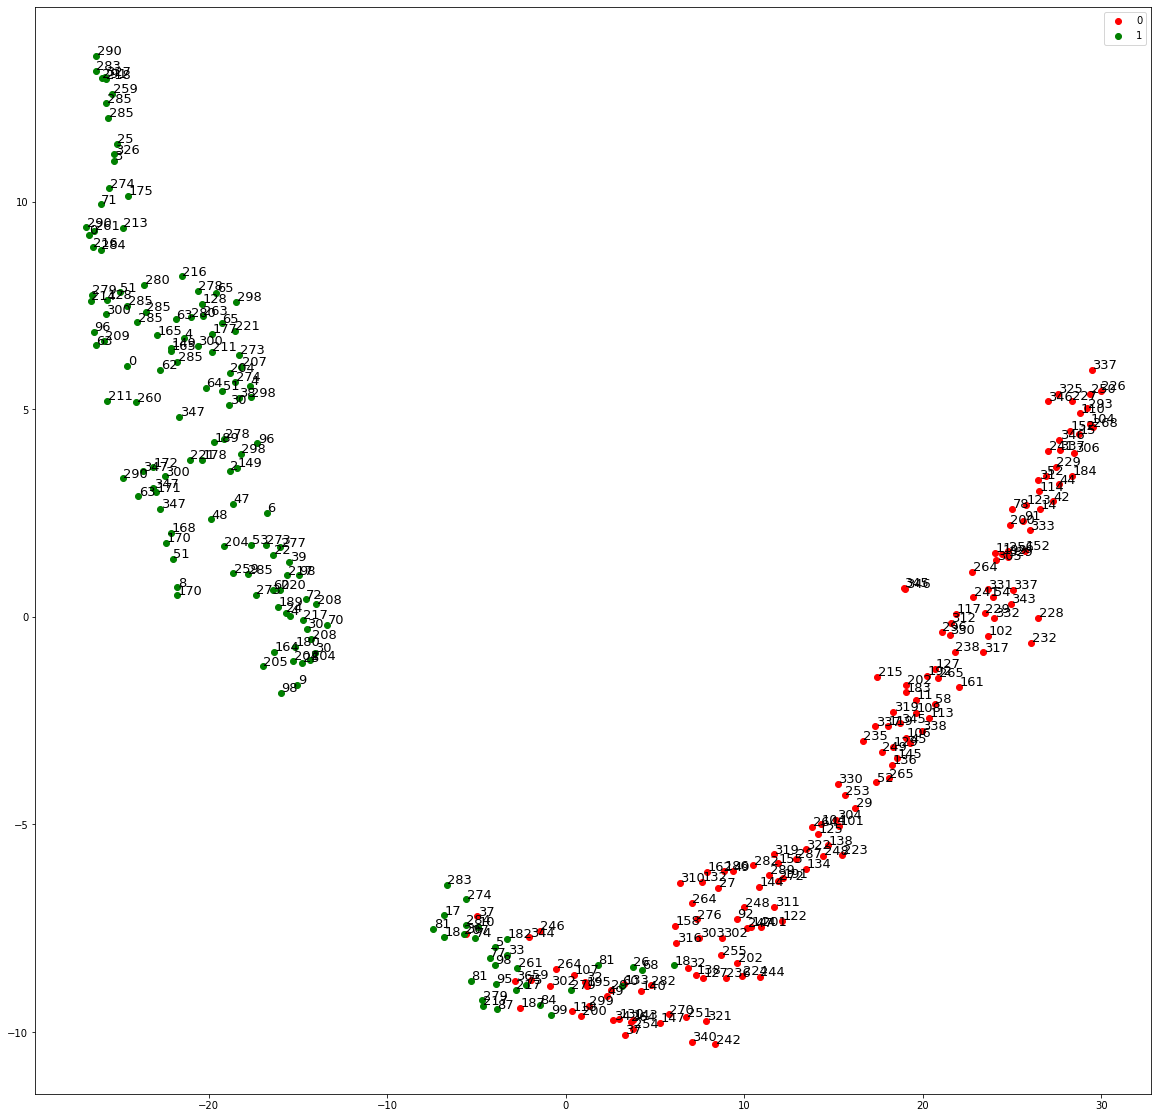

/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b4_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0908-144825/checkpoints/model_best.pth


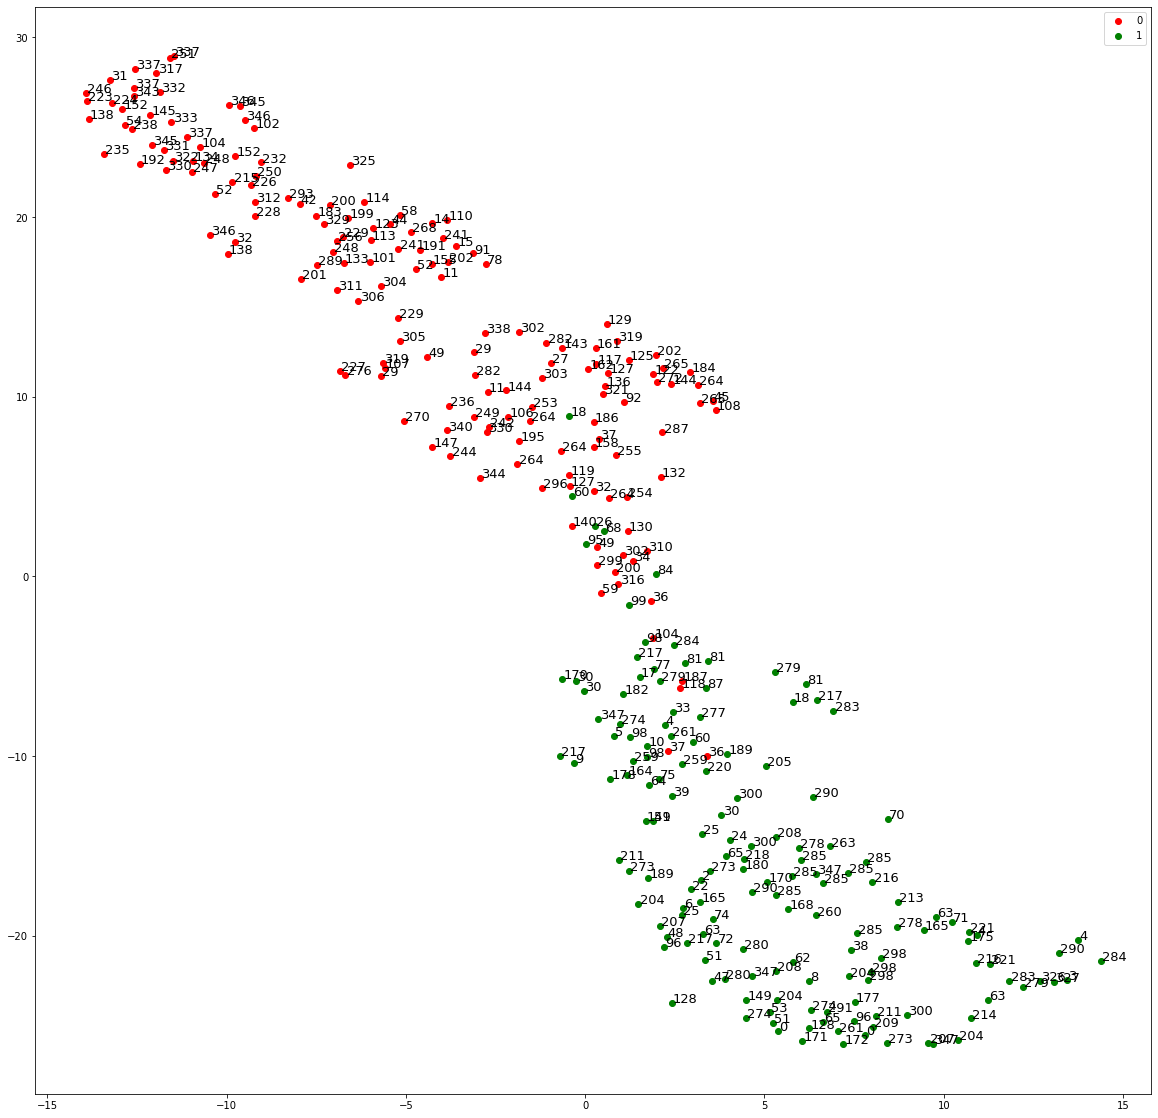

/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b3_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0912-121429/checkpoints/model_best.pth


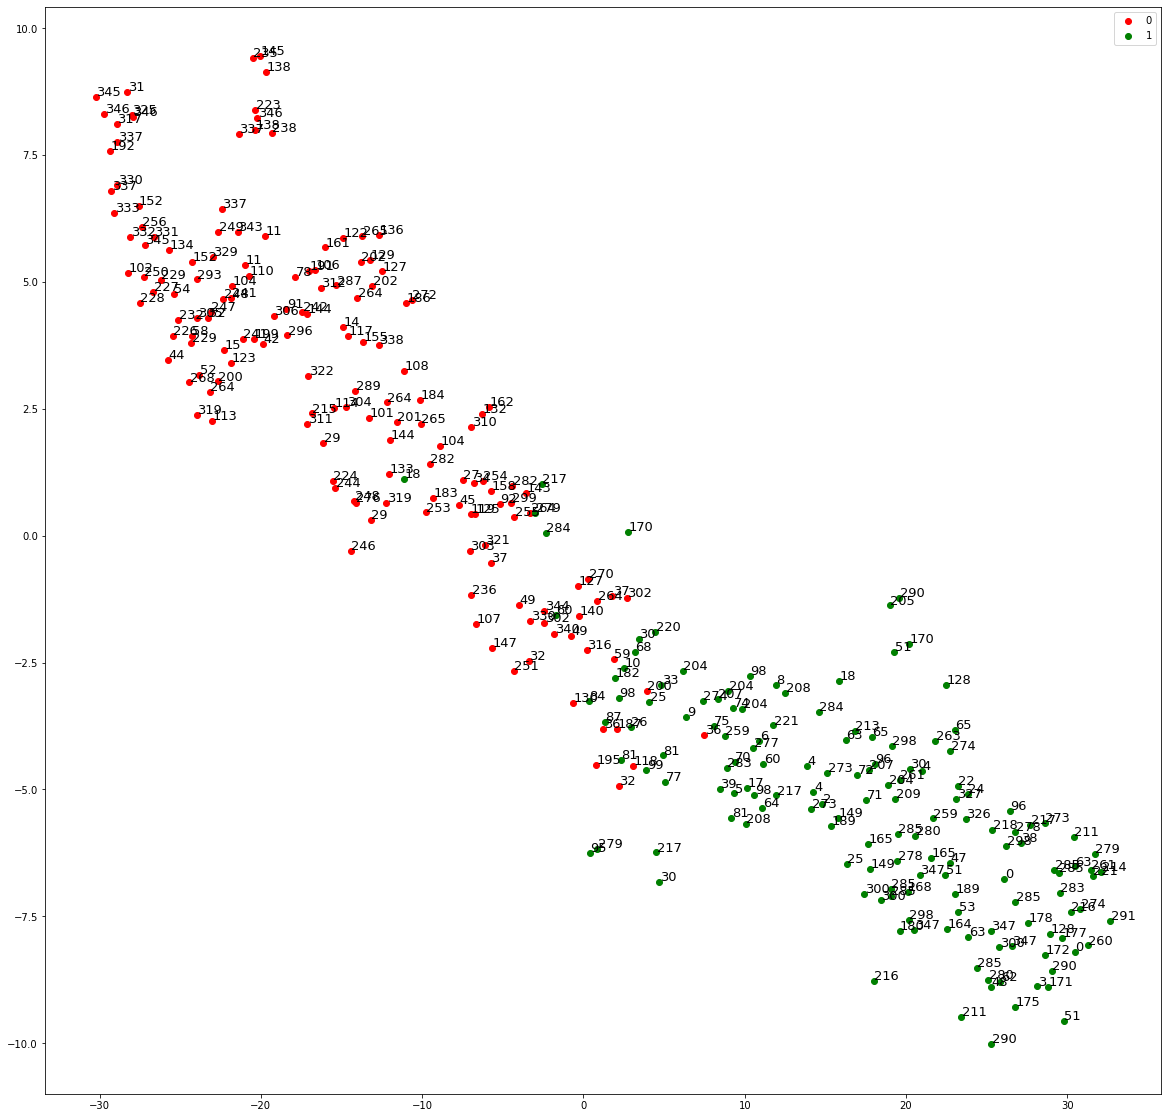

/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b1_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0913-154517/checkpoints/model_best.pth


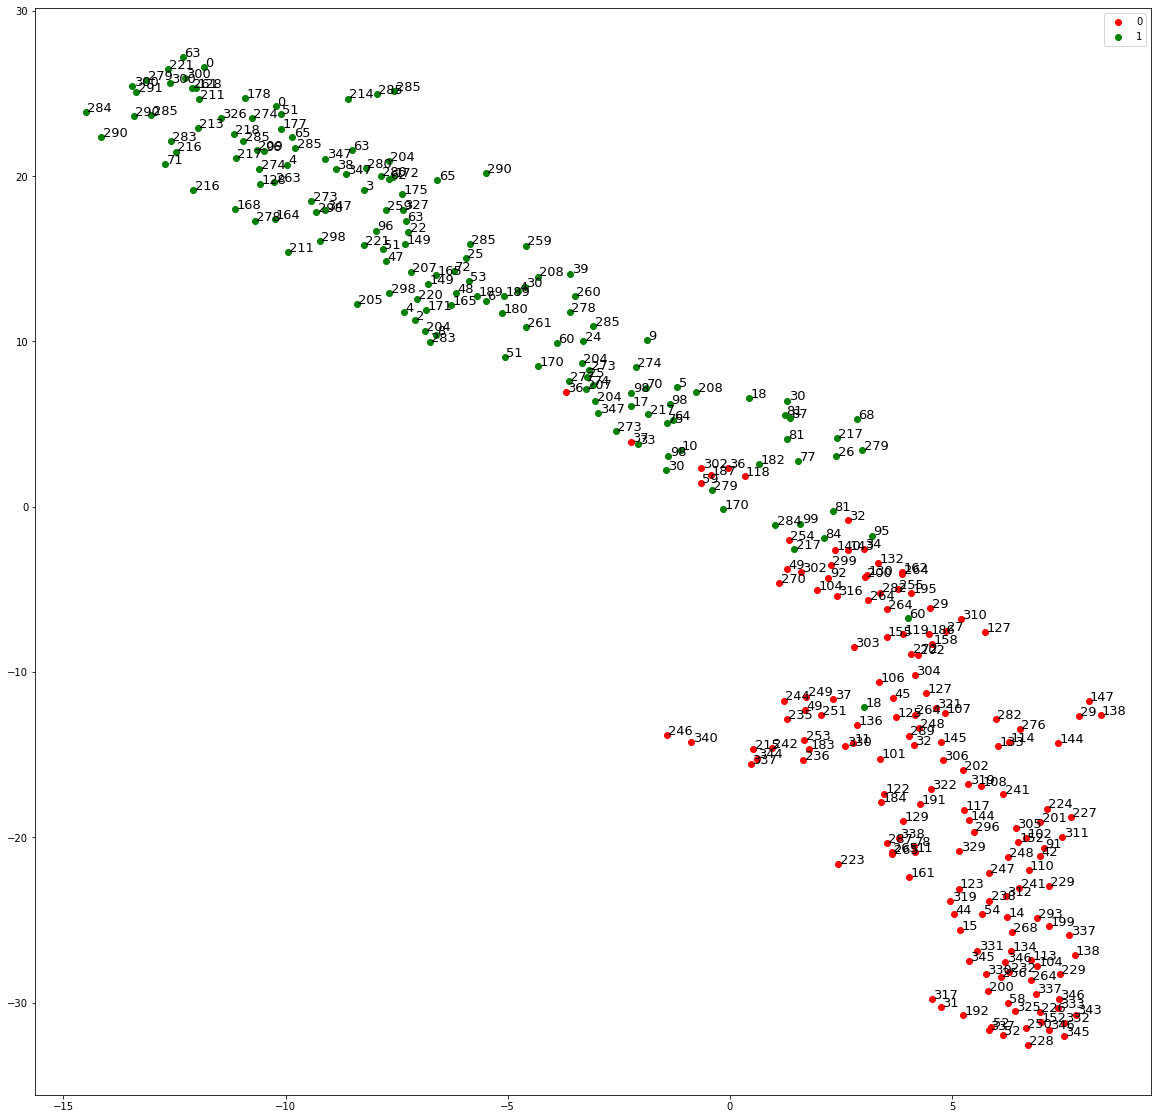

In [44]:
for model, tsne_embedding in zip(models, tsne_embeddings):
    print(model)
    aux_df = validation_df.copy()
    if WITHOUT_SYNTH_NOISE:
        aux_df = aux_df.iloc[:309, :]
        assert len(aux_df) == 309
    plt.figure(figsize=(20, 20))
    y = aux_df.target_type
    colors = ['r', 'g']
    text_column = "track_id"
    
    target_ids = aux_df.target_type.unique().tolist()
    names = list(aux_df.target_type.unique())
    for i, c, label in zip(target_ids, colors, names):
        text_values = aux_df.loc[y == i, text_column]
        plt.scatter(tsne_embedding[y == i, 0], tsne_embedding[y == i, 1], c=c, label=label)
        for text, coord_x, coord_y in zip(text_values, tsne_embedding[y == i, 0], tsne_embedding[y == i, 1]):
            plt.text(coord_x+.03, coord_y+.03, text, fontsize=13)
    plt.legend()
    plt.show()

/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0905-131049/checkpoints/model_best.pth


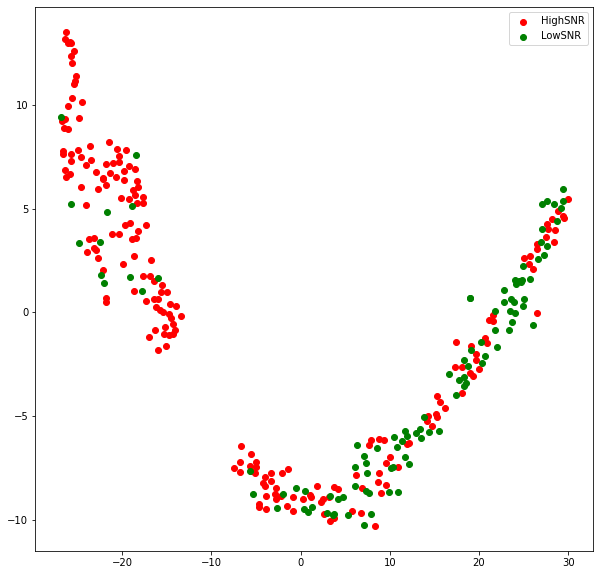

/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b4_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0908-144825/checkpoints/model_best.pth


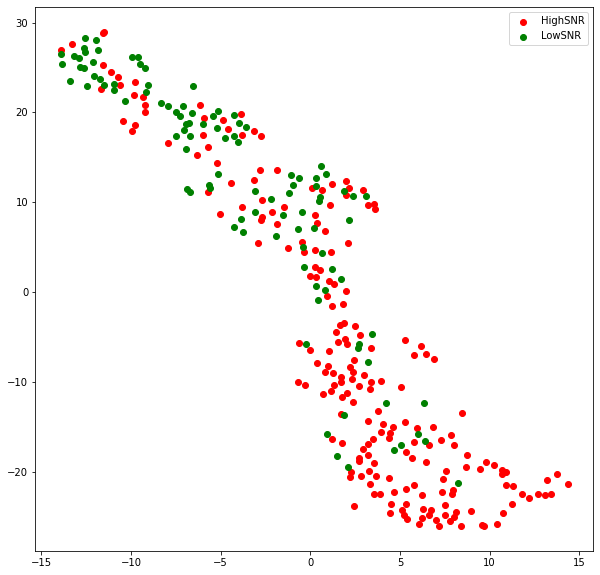

/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b3_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0912-121429/checkpoints/model_best.pth


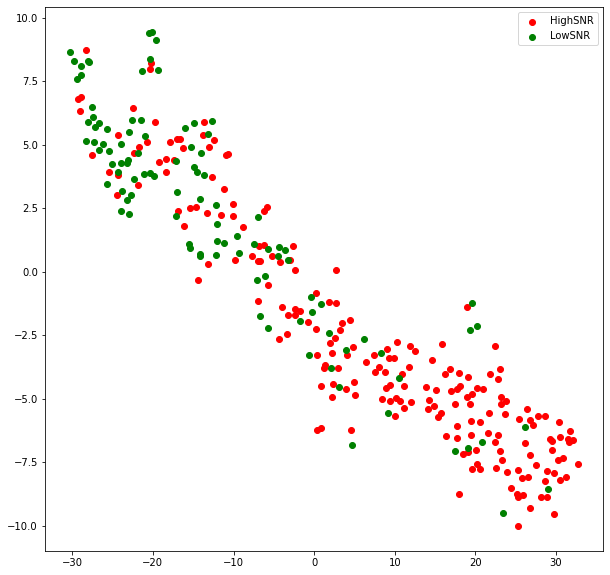

/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b1_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0913-154517/checkpoints/model_best.pth


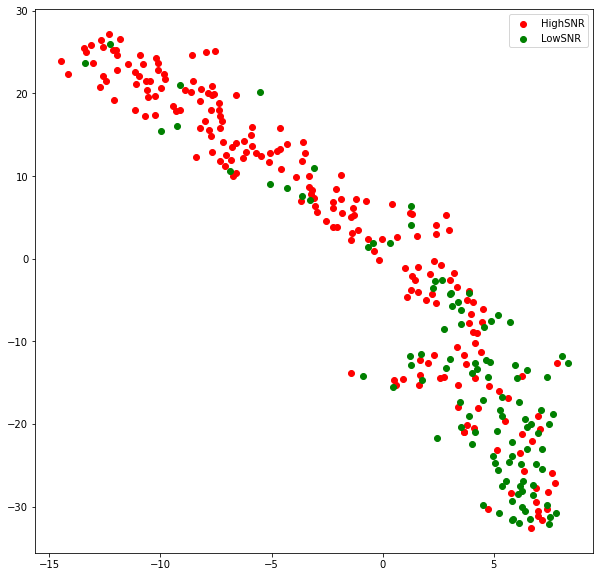

In [46]:
for model, tsne_embedding in zip(models, tsne_embeddings):
    print(model)
    plt.figure(figsize=(10, 10))
    aux_df = validation_df.copy()
    if WITHOUT_SYNTH_NOISE:
        aux_df = aux_df.iloc[:309, :]
        assert len(aux_df) == 309
    y = aux_df.snr_type
    colors = ['r', 'g', 'b']
    target_ids = aux_df.snr_type.unique().tolist()
    names = list(aux_df.snr_type.unique())
    for i, c, label in zip(target_ids, colors, names):
        plt.scatter(tsne_embedding[y == i, 0], tsne_embedding[y == i, 1], c=c, label=label)
    plt.legend()
    plt.show()

/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b5_more_aux_more_synth_specaug_simple_aug_v5_adam_sampler_02/0818-165929/checkpoints/model_best.pth


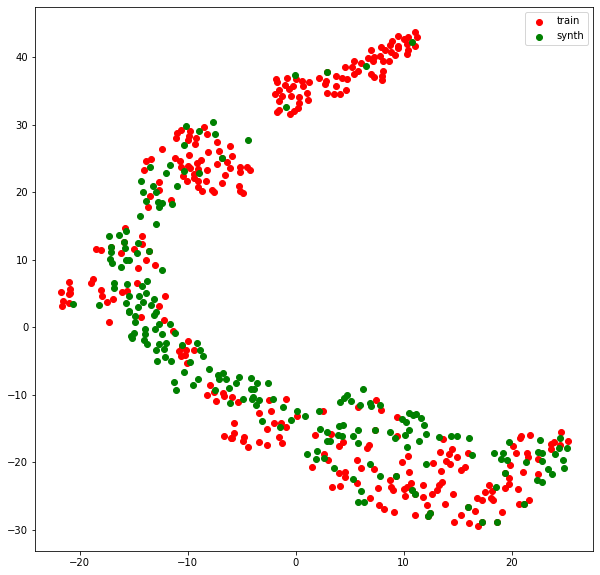

/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_simple_aug_v5_adam/0808-140236/checkpoints/model_best.pth


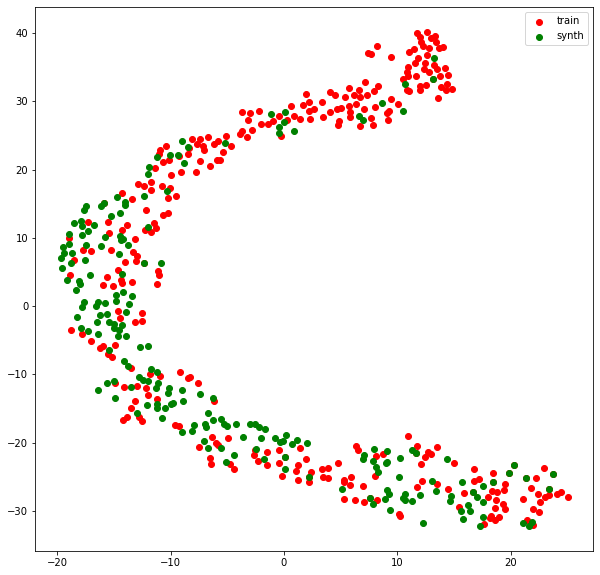

/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b3_more_aux_more_synth_specaug_simple_aug_v5_adam/0809-140258/checkpoints/model_best.pth


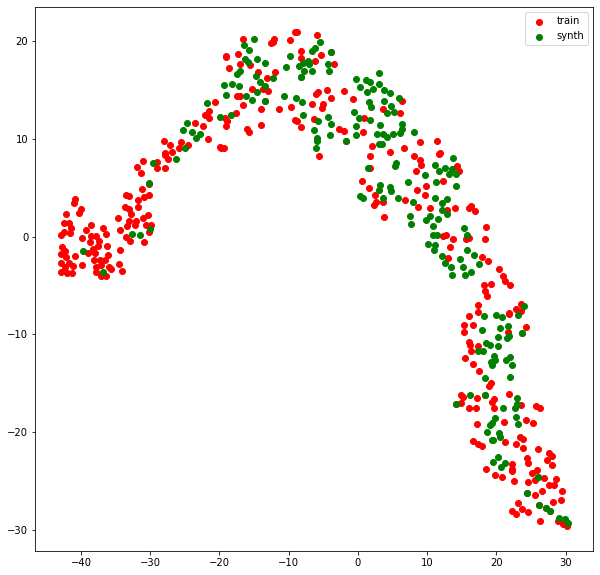

/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b4_more_aux_more_synth_specaug_simple_aug_v5_adam/0810-114753/checkpoints/model_best.pth


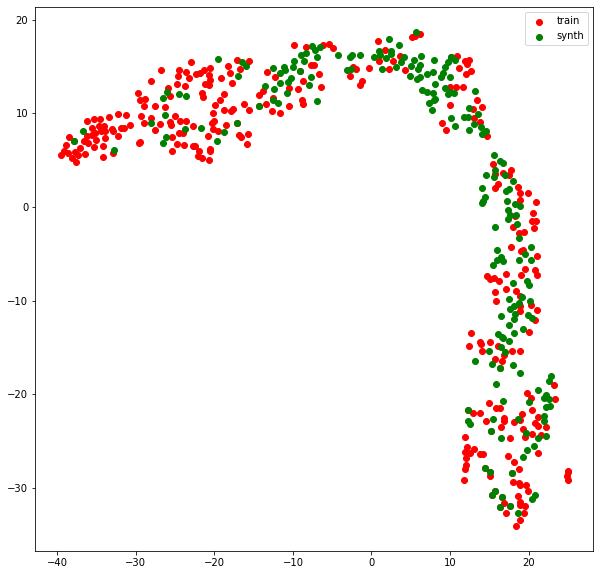

/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b4_more_aux_more_synth_specaug_simpleR_aug_v5_adam/0811-082054/checkpoints/model_best.pth


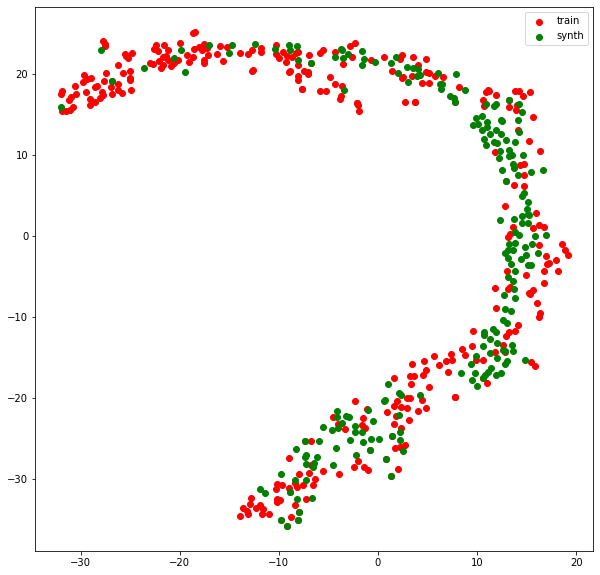

In [35]:
for model, tsne_embedding in zip(models, tsne_embeddings):
    print(model)
    plt.figure(figsize=(10, 10))
    y = validation_df.source
    colors = ['r', 'g', 'b']
    target_ids = validation_df.source.unique().tolist()
    names = list(validation_df.source.unique())
    for i, c, label in zip(target_ids, colors, names):
        plt.scatter(tsne_embedding[y == i, 0], tsne_embedding[y == i, 1], c=c, label=label)
    plt.legend()
    plt.show()

# Test dataset

In [49]:
preds_list = list()
for model_path in models:
    print(model_path)
    cfg_path = os.path.join(os.path.dirname(model_path), "config.yml")
    cfg = load_config(cfg_path)
    cfg["data_loader"] = {
        "type": "MAFATTestDataLoader", 
        "args": {
            "batch_size": 64, 
            "data_dir": "/home/agarcia/repos/mafat-radar-challenge/mafat_radar_challenge/data/mafat_test_v7_spectrogram.npy",
            "csv_dir": "/home/agarcia/repos/mafat-radar-challenge/mafat_radar_challenge/data/MAFAT RADAR Challenge - Public Test Set V1.csv",
            "nworkers": 2
        }
    }
    transforms = get_instance(module_aug, "augmentation", cfg)
    if "sampler" in cfg:
        sampler = getattr(module_sampler, cfg["sampler"]["type"])
        sampler = partial(sampler, **cfg["sampler"]["args"])
    else:
        sampler = None
    # cfg["data_loader"]["args"]["sampler"] = sampler
    data_loader = get_instance(module_data, "data_loader", cfg, transforms)
    model = get_instance(module_arch, "arch", cfg)
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint["state_dict"])
    model, device = setup_device(model, cfg["target_devices"])
    model.eval()

    test_df = data_loader.dataset.df.copy()

    counter = 0
    preds = list()
    gt = list()
    with torch.no_grad():
        for idx, image_batch in enumerate(data_loader):
            data = image_batch.to(device)
            output = model(data).cpu()
            output = torch.sigmoid(output)
            preds.append(output.cpu().numpy())

    preds = np.vstack(preds).reshape(-1).tolist()
    preds_list.append(preds)

/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0905-131049/checkpoints/model_best.pth
Loaded pretrained weights for efficientnet-b2
/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b4_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0908-144825/checkpoints/model_best.pth
Loaded pretrained weights for efficientnet-b4
/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b3_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0912-121429/checkpoints/model_best.pth
Loaded pretrained weights for efficientnet-b3
/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b1_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0913-154517/checkpoints/model_best.pth
Loaded pretrained weights for efficientnet-b1


/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0905-131049/checkpoints/model_best.pth
/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b4_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0908-144825/checkpoints/model_best.pth
	 PC:  (0.8654534361638329, 5.444255411965387e-33)


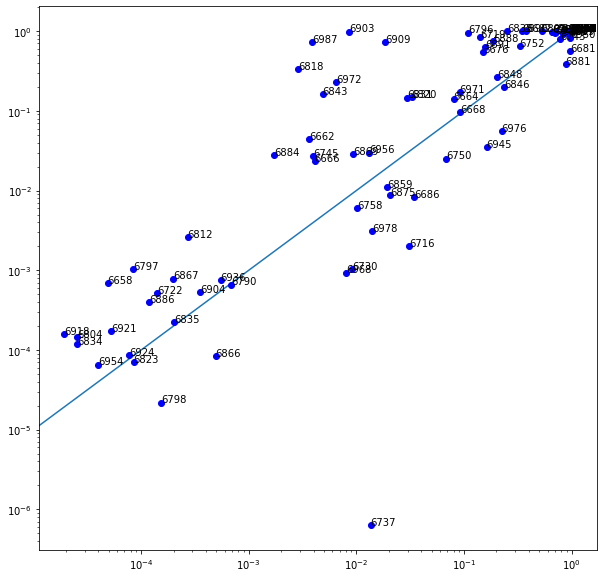

/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b4_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0908-144825/checkpoints/model_best.pth
/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b3_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0912-121429/checkpoints/model_best.pth
	 PC:  (0.884833016685919, 2.8030747265751887e-36)


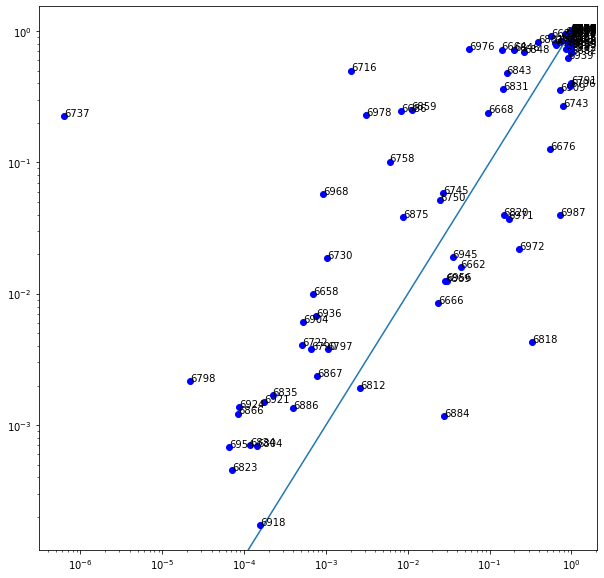

/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0905-131049/checkpoints/model_best.pth
/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b1_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0913-154517/checkpoints/model_best.pth
	 PC:  (0.8613650623083078, 2.3141922334788877e-32)


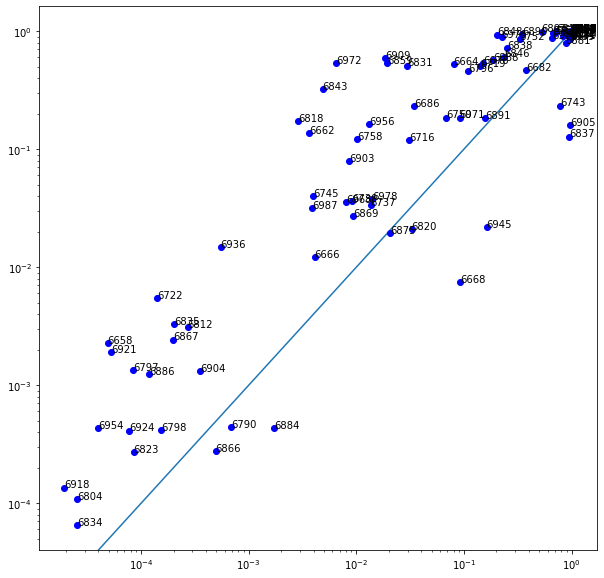

/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b3_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0912-121429/checkpoints/model_best.pth
/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b1_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0913-154517/checkpoints/model_best.pth
	 PC:  (0.904851208209376, 2.315502948481864e-40)


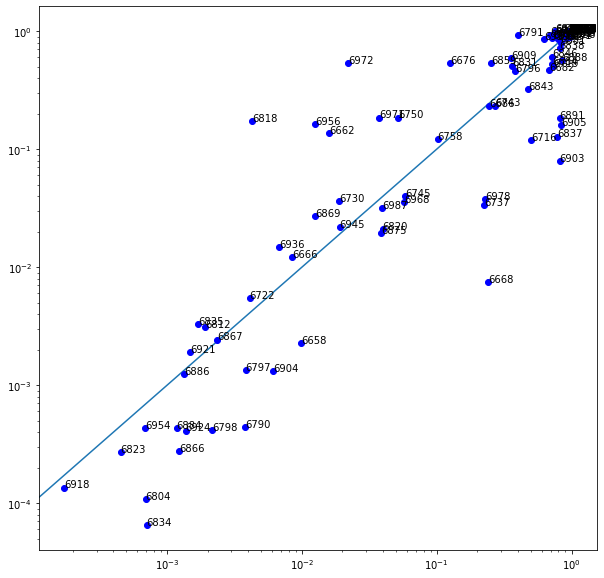

/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0905-131049/checkpoints/model_best.pth
/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b3_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0912-121429/checkpoints/model_best.pth
	 PC:  (0.8667209004072772, 3.442772429293962e-33)


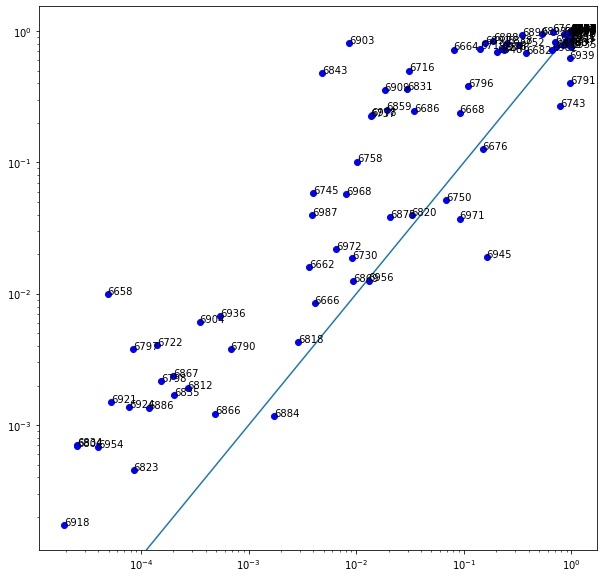

/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b4_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0908-144825/checkpoints/model_best.pth
/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b1_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0913-154517/checkpoints/model_best.pth
	 PC:  (0.8455110051004089, 4.210936077823656e-30)


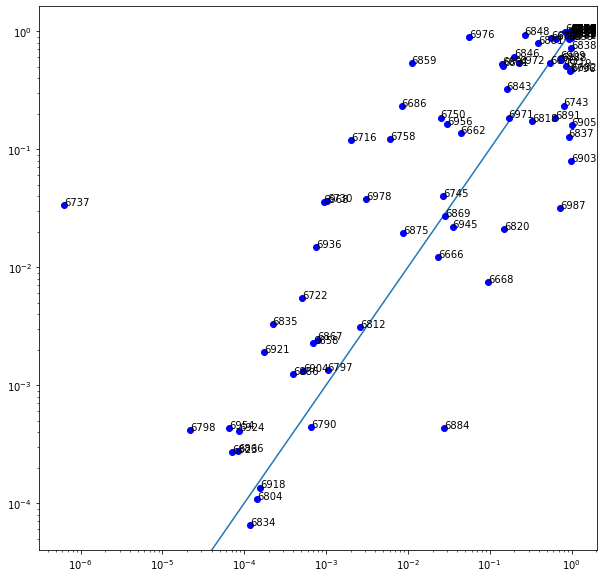

In [51]:
couples = list(itertools.combinations(range(len(models)), 2))
unique_couples = set(couples)
for unique_couple in unique_couples:
    fig, ax = plt.subplots(figsize=(10,10))
    print(models[unique_couple[0]])
    print(models[unique_couple[1]])
    print("\t PC: ", pearsonr(preds_list[unique_couple[0]], preds_list[unique_couple[1]]))
    ax.plot([0.0, 1.0], [0.0, 1.0])
    ax.loglog(preds_list[unique_couple[0]], preds_list[unique_couple[1]], 'bo')
    for i, p in enumerate(preds_list[0]):
        ax.annotate(test_df.loc[i, "segment_id"], (preds_list[unique_couple[0]][i], preds_list[unique_couple[1]][i]))
    plt.show()

/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0905-131049/checkpoints/model_best.pth
/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b4_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0908-144825/checkpoints/model_best.pth
-9.401071349685424


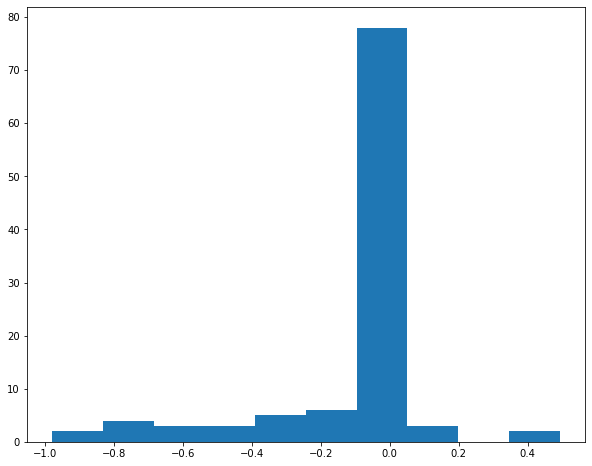

/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b4_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0908-144825/checkpoints/model_best.pth
/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b3_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0912-121429/checkpoints/model_best.pth
0.972133072568738


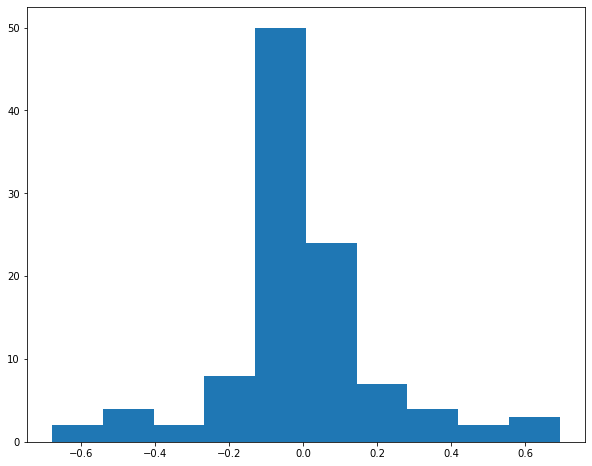

/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0905-131049/checkpoints/model_best.pth
/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b1_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0913-154517/checkpoints/model_best.pth
-7.937903604411986


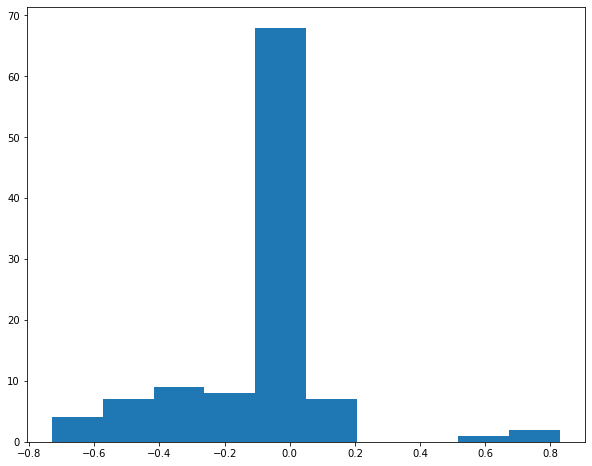

/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b3_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0912-121429/checkpoints/model_best.pth
/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b1_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0913-154517/checkpoints/model_best.pth
0.4910346727046999


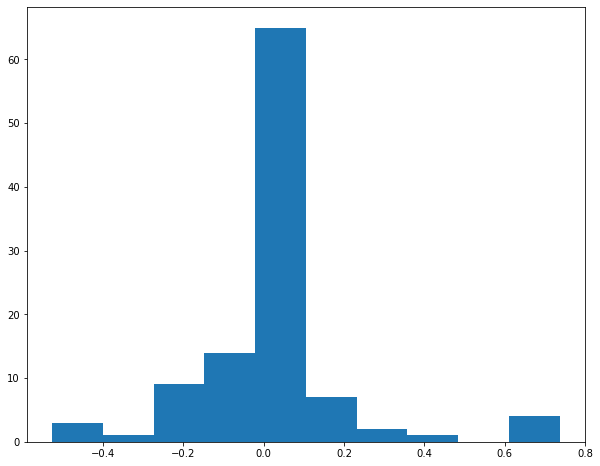

/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0905-131049/checkpoints/model_best.pth
/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b3_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0912-121429/checkpoints/model_best.pth
-8.428938277116686


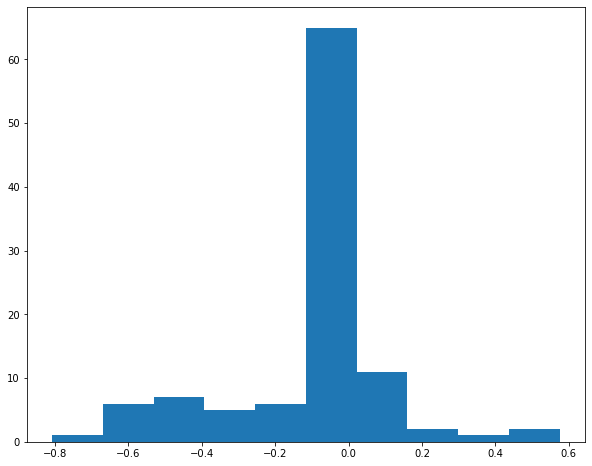

/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b4_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0908-144825/checkpoints/model_best.pth
/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b1_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0913-154517/checkpoints/model_best.pth
1.463167745273438


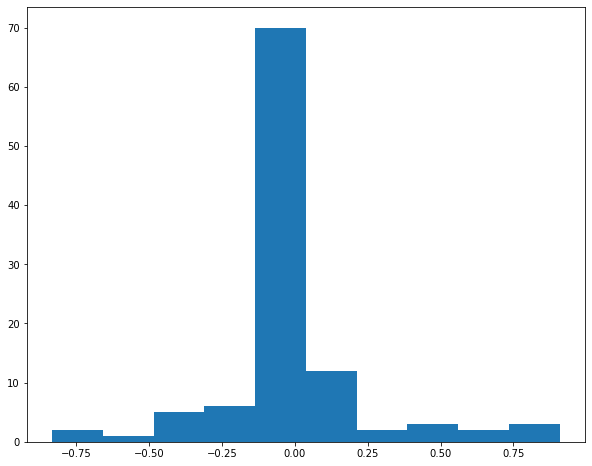

In [52]:
couples = list(itertools.combinations(range(len(models)), 2))
unique_couples = set(couples)
for unique_couple in unique_couples:
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    print(models[unique_couple[0]])
    print(models[unique_couple[1]])
    preds_one = np.array(preds_list[unique_couple[0]])
    preds_two = np.array(preds_list[unique_couple[1]])
    print(np.sum(preds_one - preds_two))
    ax.hist(preds_one - preds_two)
    plt.show()

In [53]:
max_diff_indexes = np.argsort(np.abs(np.array(preds_list[0]) - np.array(preds_list[1])))
max_diff_indexes = max_diff_indexes[::-1]
for max_diff_idx in max_diff_indexes[:5]:
    print(preds_list[0][max_diff_idx])
    print(preds_list[1][max_diff_idx])
    print(test_df.iloc[max_diff_idx, :])

0.008632613345980644
0.9871767163276672
index             72
segment_id      6903
snr_type      LowSNR
Name: 72, dtype: object
0.10876108705997467
0.9581413269042969
index             33
segment_id      6796
snr_type      LowSNR
Name: 33, dtype: object
0.2523571848869324
0.9937194585800171
index              50
segment_id       6838
snr_type      HighSNR
Name: 50, dtype: object
0.003910478670150042
0.7321179509162903
index             101
segment_id       6987
snr_type      HighSNR
Name: 101, dtype: object
0.018392419442534447
0.7334110736846924
index              75
segment_id       6909
snr_type      HighSNR
Name: 75, dtype: object


In [23]:
sorted(np.abs(np.array(preds_list[0]) - np.array(preds_list[1])))[::-1]

[0.8255296349525452,
 0.5615231990814209,
 0.5077532827854156,
 0.49030446633696556,
 0.4774518348276615,
 0.4746018350124359,
 0.4176216125488281,
 0.4044390916824341,
 0.2996551990509033,
 0.2583785653114319,
 0.2435203120112419,
 0.2255362868309021,
 0.22320335172116756,
 0.21192403137683868,
 0.2089777560904622,
 0.17854291200637817,
 0.17739099264144897,
 0.17597520351409912,
 0.16588902473449707,
 0.14756500720977783,
 0.1364964246749878,
 0.12170130014419556,
 0.106131911277771,
 0.10496944189071655,
 0.09073275327682495,
 0.08809864521026611,
 0.08426961302757263,
 0.07627631723880768,
 0.07253845036029816,
 0.07098221778869629,
 0.06644798442721367,
 0.044374287128448486,
 0.037477634847164154,
 0.035651326179504395,
 0.027804273180663586,
 0.02650093473494053,
 0.023130476474761963,
 0.022415672661736608,
 0.021476412191987038,
 0.020883619785308838,
 0.019656479358673096,
 0.01938873529434204,
 0.01377269672229886,
 0.011611546389758587,
 0.011083245277404785,
 0.01100253546

In [18]:
max_diff_indexes = np.argsort(np.abs(np.array(preds_list[0]) - np.array(preds_list[2])))
max_diff_indexes = max_diff_indexes[::-1]
for max_diff_idx in max_diff_indexes[:5]:
    print(preds_list[0][max_diff_idx])
    print(preds_list[2][max_diff_idx])
    print(test_df.iloc[max_diff_idx, :])

0.9823386073112488
0.15735957026481628
index             63
segment_id      6881
snr_type      LowSNR
Name: 63, dtype: object
0.23242641985416412
0.997231662273407
index             55
segment_id      6848
snr_type      LowSNR
Name: 55, dtype: object
0.21731239557266235
0.8540576696395874
index             20
segment_id      6743
snr_type      LowSNR
Name: 20, dtype: object
0.6749284863471985
0.05086149275302887
index              53
segment_id       6843
snr_type      HighSNR
Name: 53, dtype: object
0.8237589001655579
0.20657147467136383
index              54
segment_id       6846
snr_type      HighSNR
Name: 54, dtype: object


In [19]:
max_diff_indexes = np.argsort(np.abs(np.array(preds_list[1]) - np.array(preds_list[2])))
max_diff_indexes = max_diff_indexes[::-1]
for max_diff_idx in max_diff_indexes[:5]:
    print(preds_list[0][max_diff_idx])
    print(preds_list[2][max_diff_idx])
    print(test_df.iloc[max_diff_idx, :])

0.23242641985416412
0.997231662273407
index             55
segment_id      6848
snr_type      LowSNR
Name: 55, dtype: object
0.6749284863471985
0.05086149275302887
index              53
segment_id       6843
snr_type      HighSNR
Name: 53, dtype: object
0.8237589001655579
0.20657147467136383
index              54
segment_id       6846
snr_type      HighSNR
Name: 54, dtype: object
0.21731239557266235
0.8540576696395874
index             20
segment_id      6743
snr_type      LowSNR
Name: 20, dtype: object
0.7213683724403381
0.27888742089271545
index              13
segment_id       6716
snr_type      HighSNR
Name: 13, dtype: object


/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0905-131049/checkpoints/model_best.pth


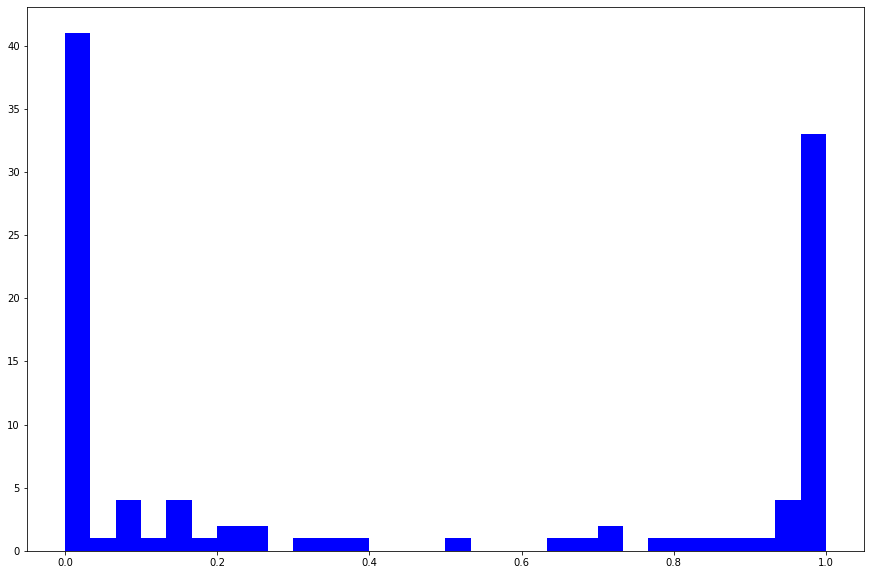

/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b4_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0908-144825/checkpoints/model_best.pth


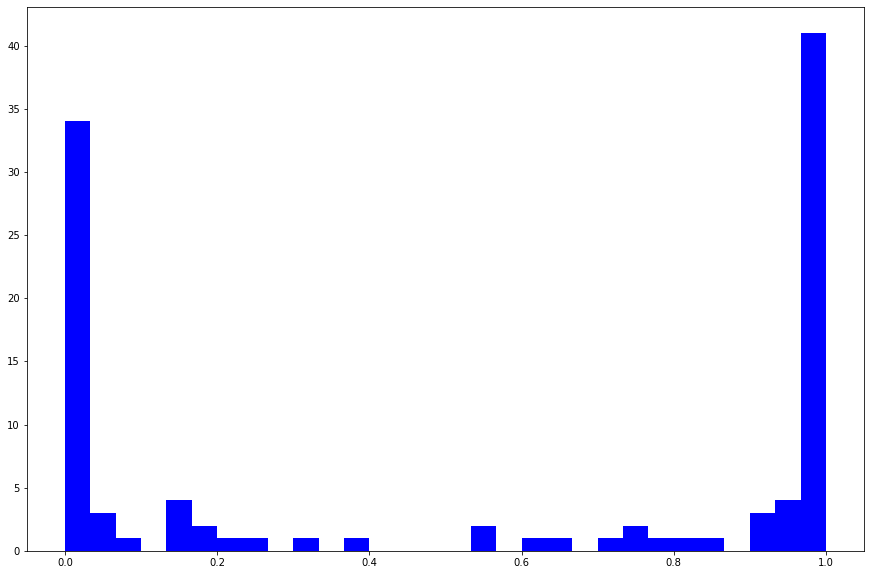

/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b3_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0912-121429/checkpoints/model_best.pth


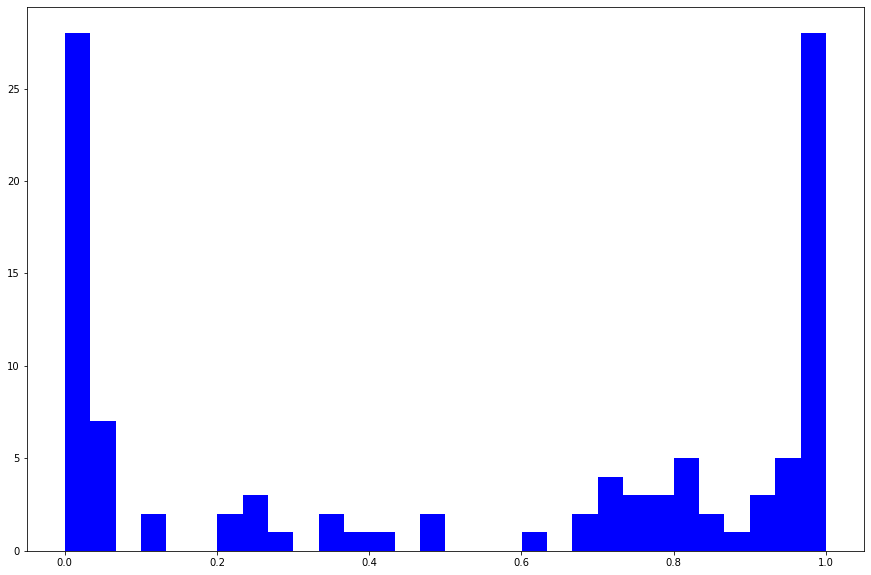

/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b1_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0913-154517/checkpoints/model_best.pth


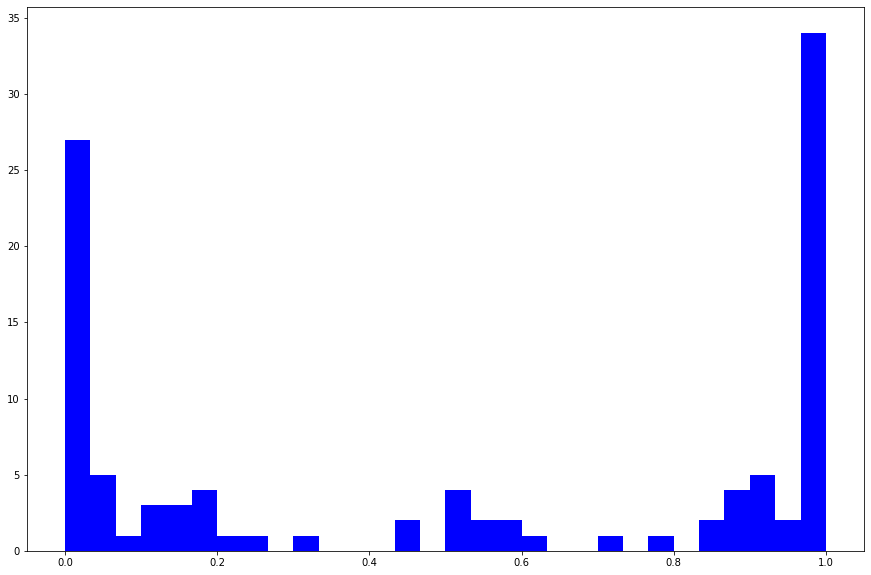

In [54]:
for model, preds in zip(models, preds_list):
    print(model)
    fig = plt.figure(figsize=(15,10))
    ax1 = fig.add_subplot(111)
    ax1.hist(preds, log=False, cumulative=False, bins=30, color='blue')
    plt.show()

In [55]:
df_list = []
idx = 0
concat_df = pd.DataFrame()
for model, preds in zip(models, preds_list):
    aux_df = test_df.copy()
    model_alias = model.split(os.sep)[-4]
    print(model_alias)
    aux_df["score"] = preds
    aux_df["segment_id"] = list(range(aux_df.shape[0]))
    aux_df = aux_df.sort_values("score")    
    concat_df["score" + str(idx)] = aux_df.score
    concat_df["segment_id" + str(idx)] = aux_df.copy().segment_id.values
    df_list.append(aux_df.copy())
    idx += 1
concat_df

MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_simple_aug_v5_adam_centered
MAFAT_replica_aug_eff_b4_more_aux_more_synth_specaug_simple_aug_v5_adam_centered
MAFAT_replica_aug_eff_b3_more_aux_more_synth_specaug_simple_aug_v5_adam_centered
MAFAT_replica_aug_eff_b1_more_aux_more_synth_specaug_simple_aug_v5_adam_centered


,score0,segment_id0,score1,segment_id1,score2,segment_id2,score3,segment_id3
76,0.000019,76,0.000157,19,0.000173,76,0.000136,46
37,0.000025,37,0.000144,35,0.000693,43,0.000108,37
46,0.000025,46,0.000119,89,0.000705,89,0.000065,76
89,0.000040,89,0.000066,43,0.000684,37,0.000431,43
1,0.000049,1,0.000692,57,0.009914,46,0.002282,57
...,...,...,...,...,...,...,...,...
71,0.999998,71,0.999990,71,0.999995,59,0.999978,44
51,0.999998,51,0.999946,10,0.999994,95,0.999998,95
52,0.999999,52,1.000000,16,1.000000,91,1.000000,24
95,1.000000,95,1.000000,52,1.000000,16,0.999996,51


## T-SNE

In [56]:
cfg

{'arch': {'args': {'net_name': 'efficientnet-b1',
   'num_classes': 1,
   'pretrained': True},
  'type': 'EfficientNetBase'},
 'augmentation': {'args': {'image_size': [240, 60]},
  'type': 'ImgAugExpTransform'},
 'data_loader': {'type': 'MAFATTestDataLoader',
  'args': {'batch_size': 64,
   'data_dir': '/home/agarcia/repos/mafat-radar-challenge/mafat_radar_challenge/data/mafat_test_v7_spectrogram.npy',
   'csv_dir': '/home/agarcia/repos/mafat-radar-challenge/mafat_radar_challenge/data/MAFAT RADAR Challenge - Public Test Set V1.csv',
   'nworkers': 2}},
 'sampler': {'args': {'p': 0.2}, 'type': 'WeightedSourceSampler'},
 'loss': {'args': {'pos_weight': 1},
  'type': 'binary_cross_entropy_with_logits'},
 'lr_scheduler': {'args': {'gamma': 0.3, 'step_size': 10}, 'type': 'StepLR'},
 'metrics': ['auc_score_metric', 'average_classification_error_rate'],
 'name': 'MAFAT_replica_aug_eff_b1_more_aux_more_synth_specaug_simple_aug_v5_adam_centered',
 'optimizer': {'args': {'lr': 0.001, 'weight_dec

In [57]:
# cfg = load_config(CONFIG_PATH)
output_list = list()
for model_path in models:
    # Setup
    cfg = load_config(os.path.join(os.path.dirname(model_path), "config.yml"))
    transforms = get_instance(module_aug, "augmentation", cfg)
    
    # Adapt for testing      
    del cfg["data_loader"]["args"]["shuffle"]
    if "use_metadata" in cfg["data_loader"]["args"]:
        del cfg["data_loader"]["args"]["use_metadata"]
    cfg["data_loader"]["type"] = "MAFATTestDataLoader"
    cfg["data_loader"]["args"]["data_dir"] = "/home/agarcia/repos/mafat-radar-challenge/mafat_radar_challenge/data/mafat_test_v7_spectrogram.npy"
    cfg["data_loader"]["args"]["csv_dir"] = "/home/agarcia/repos/mafat-radar-challenge/mafat_radar_challenge/data/MAFAT RADAR Challenge - Public Test Set V1.csv"
    cfg["data_loader"]["args"]["train"] = False
    
    data_loader = get_instance(module_data, "data_loader", cfg, transforms)
    model = get_instance(module_arch, "arch", cfg)
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint["state_dict"])
    model, device = setup_device(model, cfg["target_devices"])
    model.eval()

    # Predict
    preds = list()
    outputs = list()
    preds = list()
    with torch.no_grad():
        for idx, image_batch in enumerate(data_loader):
            data = image_batch.to(device)
            output = model.model.extract_features(data).cpu()
            output = model.model._avg_pooling(output)
            output = output.flatten(1)
            outputs.append(output.numpy())
    
    outputs = np.vstack(outputs)                
    
    output_list.append(outputs)

Loaded pretrained weights for efficientnet-b2
Loaded pretrained weights for efficientnet-b4
Loaded pretrained weights for efficientnet-b3
Loaded pretrained weights for efficientnet-b1


In [58]:
from sklearn.manifold import TSNE
tsne_embeddings = list()

for outputs in zip(output_list):
    outputs = outputs[0]
    X_embedded = TSNE(n_components=2).fit_transform(outputs)
    tsne_embeddings.append(X_embedded)

In [63]:
test_df = data_loader.dataset.df

/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0905-131049/checkpoints/model_best.pth


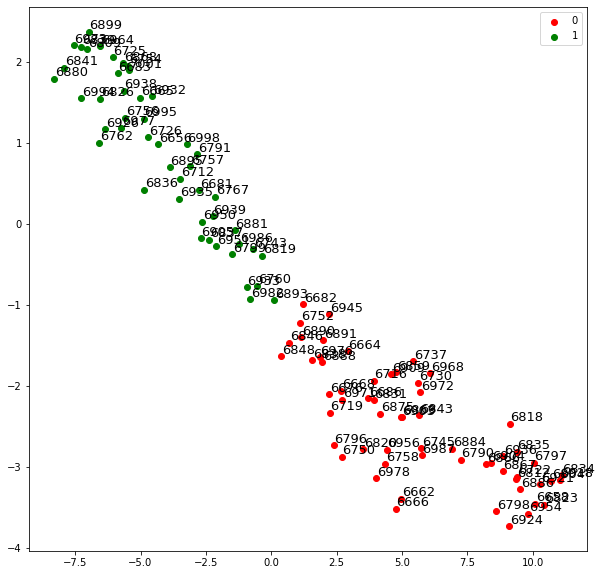

/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b4_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0908-144825/checkpoints/model_best.pth


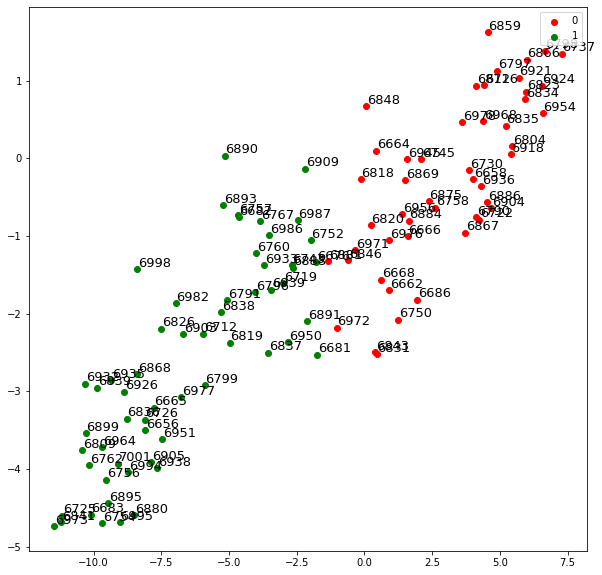

/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b3_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0912-121429/checkpoints/model_best.pth


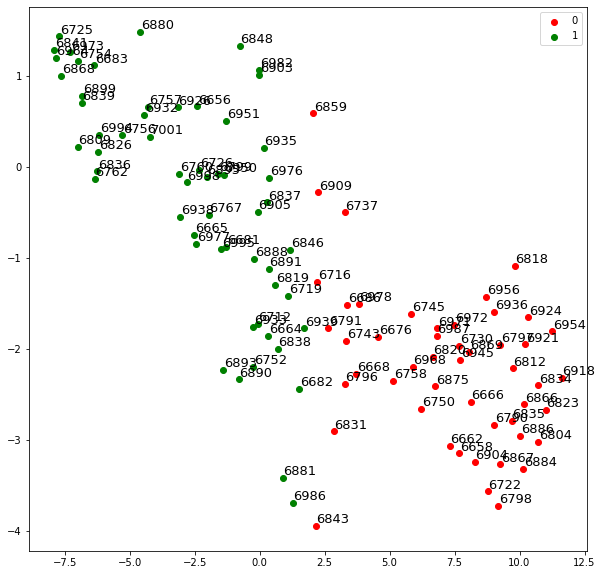

/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b1_more_aux_more_synth_specaug_simple_aug_v5_adam_centered/0913-154517/checkpoints/model_best.pth


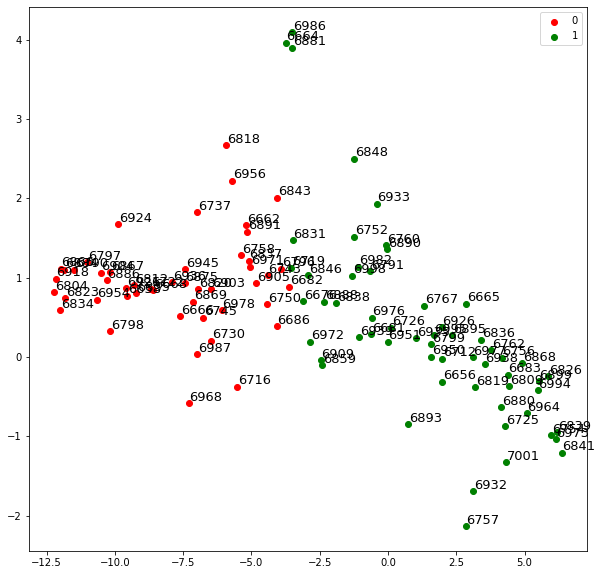

In [70]:
# TODO: Print with colors, using 0.5
for model, tsne_embedding, outputs in zip(models, tsne_embeddings, preds_list):
    print(model)
    plt.figure(figsize=(10, 10))
    y = np.array([1 if x > 0.5 else 0 for x in outputs])
    colors = ['r', 'g']
    text_column = "segment_id"
    names = ["0", "1"]
    target_ids = [0, 1]       
    
    for i, c, label in zip(target_ids, colors, names):
        text_values = test_df.loc[y == i, text_column] 
        plt.scatter(tsne_embedding[y == i, 0], tsne_embedding[y == i, 1], c=c, label=label)
        for text, coord_x, coord_y in zip(text_values, tsne_embedding[y == i, 0], tsne_embedding[y == i, 1]):
            plt.text(coord_x+.03, coord_y+.03, text, fontsize=13)
    plt.legend()
    plt.show()

In [165]:
preds_list

[]